<link rel="stylesheet" href="/site-assets/css/style.css">
<link rel="stylesheet" href="/site-assets/css/gemma.css">


##### Copyright 2024 Google LLC.

# Fine-tune PaliGemma with JAX and Flax

<table class="tfo-notebook-buttons" align="left">
<td>
<a target="_blank" href="https://ai.google.dev/gemma/docs/paligemma/fine-tuning-paligemma"><img src="https://ai.google.dev/static/site-assets/images/docs/notebook-site-button.png" height="32" width="32" />View on ai.google.dev</a>
</td>
<td>
<a target="_blank" href="https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/gemma/docs/paligemma/fine-tuning-paligemma.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td>
<td>
<a target="_blank" href="https://github.com/google/generative-ai-docs/blob/main/site/en/gemma/docs/paligemma/fine-tuning-paligemma.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td>
</table>

This notebook shows how to fine-tune [PaliGemma](https://ai.google.dev/gemma/docs/paligemma) on a vision-language task with [JAX](https://jax.readthedocs.io/en/latest/index.html). *Fine-tuning* is a process that can improve your model's performance on specific tasks or help the model adhere to specific output requirements when instructions aren't sufficient and you have a set of examples that demonstrate the outputs you want. Gemma-based models like PaliGemma require fine-tuning to produce expected results.

### What's in this notebook

This notebook uses the model reference implementation from [`big_vision`](https://github.com/google-research/big_vision)
and shows how to:

 * Install dependencies, and download the PaliGemma model checkpoint and training data
 * Load the model onto GPU devices
 * Prepare the model's inputs for training and inference
 * Fine-tune the model
 * Inspect the output

The training data for this notebook consists of 90 pairs of images and long captions describing them. To make it runnable on a T4 colab runtime, you'll only fine-tune the attention layers of the language model and freeze the other parameters.

This example is for learning purposes only. In a real use case, the amount of data, trainable parameters, training steps and hyper-parameters, and obtained results could be significantly different.

### Before you begin

Before going through this notebook, you should be familiar with Python code, as well as how large language models (LLMs) are trained. You don't need to be familiar with JAX, but basic knowledge about JAX (or similar technologies such as Keras) is helpful when reading through the example code.

## Setup

The following sections explain the preliminary steps for getting a notebook to use a PaliGemma model, including model access, getting an API key, and configuring the notebook runtime.

### Get access to PaliGemma

Before using PaliGemma for the first time, you must request access to the model through Kaggle by completing the following steps:

1. Log in to [Kaggle](https://www.kaggle.com), or create a new Kaggle account if you don't already have one.
1. Go to the [PaliGemma model card](https://www.kaggle.com/models/google/paligemma-2) and click **Request Access**.
1. Complete the consent form and accept the terms and conditions.

### Configure your API key

To use PaliGemma, you must provide your Kaggle username and a Kaggle API key.

To generate a Kaggle API key, open your [**Settings** page in Kaggle](https://www.kaggle.com/settings) and click **Create New Token**. This triggers the download of a `kaggle.json` file containing your API credentials.

Then, in Colab, select **Secrets** (🔑) in the left pane and add your Kaggle username and Kaggle API key. Store your username under the name `KAGGLE_USERNAME` and your API key under the name `KAGGLE_KEY`.


### Select the runtime

To complete this tutorial, you'll need to have a Colab runtime with sufficient resources to run the PaliGemma model. In this case, you can use a T4 GPU:

1. In the upper-right of the Colab window, click the **▾ (Additional connection options)** dropdown menu.
1. Select **Change runtime type**.
1. Under **Hardware accelerator**, select **T4 GPU**.

### Set environment variables

Set the environment variables for `KAGGLE_USERNAME` and `KAGGLE_KEY`.

In [3]:
import os
# from google.colab import userdata

# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate or make your credentials available in ~/.kaggle/kaggle.json

os.environ["KAGGLE_USERNAME"] = 'dhruvagarwal1'
os.environ["KAGGLE_KEY"] = 'd494c3f77be2e8080f95596bac32ecd9'
os.environ["CUDA_VISIBLE_DEVICES"] = "6, 7"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"



# The T4 runtime is tight on memory to finetune this model. Preallocate
# all memory ahead of time to avoid out-of-memory due to fragmentation.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.0"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"


### Fetch the `big_vision` repository and install related dependencies

Download the `big_vision` repository to your Colab notebook from GitHub and install dependencies related to `big_vision` by running the following code.

In [4]:
import os
import sys
import flax.serialization
import msgpack
# TPUs with
# if "COLAB_TPU_ADDR" in os.environ:
#   raise "It seems you are using Colab with remote TPUs which is not supported."

# Fetch big_vision repository if python doesn't know about it and install
# dependencies needed for this notebook.
if not os.path.exists("big_vision_repo"):
  !git clone --quiet --branch=main --depth=1 \
     https://github.com/google-research/big_vision big_vision_repo

# Append big_vision code to python import path
if "big_vision_repo" not in sys.path:
  sys.path.append("big_vision_repo")

# Install missing dependencies. Assume jax~=0.4.25 with GPU available.
!pip3 install -q "overrides" "ml_collections" "einops~=0.7" "sentencepiece"


### Import JAX and other dependencies

Import JAX and other dependencies required for PaliGemma, like TensorFlow and NumPy.

In [6]:
import base64
import functools
import html
import io
import os
import warnings

import jax
import jax.numpy as jnp
import numpy as np
import ml_collections

import tensorflow as tf
import sentencepiece

from IPython.display import display, HTML
from PIL import Image

# Import model definition from big_vision
from big_vision.models.proj.paligemma import paligemma
from big_vision.trainers.proj.paligemma import predict_fns

# Import big vision utilities
import big_vision.datasets.jsonl
import big_vision.utils
import big_vision.sharding



# Don't let TF use the GPU or TPUs
# tf.config.set_visible_devices(["cuda:1"], "GPU")
# tf.config.set_visible_devices([], "TPU")

backend = jax.extend.backend.get_backend()
print(f"JAX version:  {jax.__version__}")
print(f"JAX platform: {backend.platform}")
print(f"JAX devices:  {jax.device_count()}")

def save_checkpoint(params, step, save_dir="checkpoints"):
    os.makedirs(save_dir, exist_ok=True)
    path = os.path.join(save_dir, f"checkpoint_new_llm_variant{step:04d}.msgpack")
    with open(path, "wb") as f:
        f.write(flax.serialization.to_bytes(params))
    print(f"✅ Saved checkpoint to: {path}")


JAX version:  0.6.0
JAX platform: gpu
JAX devices:  2


## Download and configure the model

In this step, you'll download the model checkpoint and configure it so that you can fine-tune it later on. This step shows you how to move model parameters into TPU memory, which is useful for fine-tuning models on devices with limited resources.

### Download the model checkpoint

PaliGemma includes several model variations. For this tutorial, you'll use the base [JAX/FLAX PaliGemma 3B weight model](https://www.kaggle.com/models/google/paligemma-2/jax/paligemma2-3b-pt-224).

Download the model checkpoint from Kaggle by running the following code. This process takes several minutes to complete.

In [7]:
import os
import kagglehub

# Use these for PaliGemma-2 3B 224px²
# LLM_VARIANT = "gemma2_2b"
# MODEL_PATH = "./paligemma2-3b-pt-224.b16.npz"
# KAGGLE_HANDLE = "google/paligemma-2/jax/paligemma2-3b-pt-224"  # Path to fetch from Kaggle.

# Use these for Paligemma 2 with 896x896 images
LLM_VARIANT = "gemma2_3b"
MODEL_PATH = "./paligemma2-3b-pt-896.b16.npz"
KAGGLE_HANDLE = "google/paligemma-2/jax/paligemma2-3b-pt-896"

# Use these for Paligemma with 224x224 images
# LLM_VARIANT = "gemma_2b"
# MODEL_PATH = "./paligemma-3b-pt-224.f16.npz"
# KAGGLE_HANDLE = "google/paligemma/jax/paligemma-3b-pt-224"

if not os.path.exists(MODEL_PATH):
  print("Downloading the checkpoint from Kaggle, this could take a few minutes....")
  MODEL_PATH = kagglehub.model_download(KAGGLE_HANDLE, MODEL_PATH)
  print(f"Model path: {MODEL_PATH}")

TOKENIZER_PATH = "./paligemma_tokenizer.model"
if not os.path.exists(TOKENIZER_PATH):
  print("Downloading the model tokenizer...")
  !gsutil cp gs://big_vision/paligemma_tokenizer.model {TOKENIZER_PATH}
  print(f"Tokenizer path: {TOKENIZER_PATH}")

# DATA_DIR="./longcap100"
# if not os.path.exists(DATA_DIR):
#   print("Downloading the dataset...")
#   !gsutil -m -q cp -n -r gs://longcap100/ .
#   print(f"Data path: {DATA_DIR}")

/home/henrytsai/anaconda3/envs/dhruv2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model path: /home/henrytsai/.cache/kagglehub/models/google/paligemma-2/jax/paligemma2-3b-pt-896/1/./paligemma2-3b-pt-896.b16.npz


### Configure the model

It's time to actually start configuring the model that you're going to use.

For this notebook, you need to be able to fit your model onto a T4 GPU. Having a limited resource like space constraints means that you have to be mindful of how your model is configured.

If you fine-tune every parameter, your model won't be able to run in the notebook environment. As a result, in this part of the notebook, you'll configure your model so that it has the ability to freeze some of the parameters, and only fine-tune the parameters that really need to be fine-tuned for the model to give you accurate results. In LLMs, parameters are said to be *frozen* when they are no longer actively being used to train the model.

In order to configure your model, you need to:

* Initialize the `model_config` as a [`FrozenConfigDict`](https://github.com/google/ml_collections/tree/master#frozenconfigdict) so that you can freeze some of the parameters and keep memory usage low
* Initialize an instance of the PaliGemma `Model` class using the `model_config` as its configurations
* Load the model parameters into RAM
* Define a `decode` function to sample outputs from the model

This code in this cell takes about a minute to run to completion.

In [8]:
import tensorflow_datasets as tfds
import numpy as np
from PIL import Image
import io

def preprocess_droid_episode(episode, num_frames=4):
    frames = []
    for step in episode["steps"][:num_frames]:
        img = step["observation"]["wrist_image_left"].numpy()
        frames.append(Image.fromarray(img))
    
    # Use the main instruction for training target
    target_text = episode["steps"][0]["language_instruction"].numpy().decode("utf-8")
    
    return frames, target_text

def stack_images_horizontally(images):
    widths, heights = zip(*(img.size for img in images))
    new_im = Image.new('RGB', (sum(widths), max(heights)))
    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset, 0))
        x_offset += im.width
    return new_im


In [9]:
# Define model

# IMPORTANT: Gemma-2 has a "final_logits_softcap" property. Set it to 0.0
# for better transfer results.
model_config = ml_collections.FrozenConfigDict({
    "llm": {"vocab_size": 257216, "variant": LLM_VARIANT, "final_logits_softcap": 0.0},
    "img": {"variant": "So400m/14", "pool_type": "none", "scan": True, "dtype_mm": "float16"}
})
model = paligemma.Model(**model_config)
tokenizer = sentencepiece.SentencePieceProcessor(TOKENIZER_PATH)

# Load params - this can take up to 1 minute in T4 colabs.
params = paligemma.load(None, MODEL_PATH, model_config)

# Define `decode` function to sample outputs from the model.
decode_fn = predict_fns.get_all(model)['decode']
decode = functools.partial(decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id())

### Move model parameters into GPU/TPU memory

Now you need to move the model parameters into GPU/TPU memory. First, shard the parameters across the available GPUs, then load the parameters. Here, you'll load the parameters sequentially. This process takes longer than loading them simultaneously, but it requires more RAM than you have available in this notebook.

Finally, print out all of the parameters to see what type each individual parameter is cast to. Frozen parameters are kept as `float16`, while the trainable parameters are cast to `float32`. When you inspect the list, you'll see that most of the parameters have been frozen and are `float16`.

In [13]:
# Create a pytree mask of the trainable params.
def is_trainable_param(name, param):  # pylint: disable=unused-argument
  if name.startswith("llm/layers/attn/"):
    return True
  if name.startswith("img/Transformer/encoderblock/MultiHeadDotProductAttention_0"):
    return True
  # if name.startswith("img/head/"):
  #   return True
  # if name.startswith("img/Transformer/encoderblock/"):
  #   # Match: img/Transformer/encoderblock/<index>/...
  #   parts = name.split("/")
  #   if len(parts) > 3 and parts[2].startswith("encoderblock"):
  #     try:
  #       block_num = int(parts[3])  # parts[3] is the block index
  #       return block_num >= 23  # Unfreeze last 4 blocks
  #     except ValueError:
  #       pass  # Ignore any malformed names
  if name.startswith("llm/"):
    return False
  if name.startswith("img/"):
    return False
  raise ValueError(f"Unexpected param name {name}")

trainable_mask = big_vision.utils.tree_map_with_names(is_trainable_param, params)

# If more than one device is available (e.g. multiple GPUs) the parameters can
# be sharded across them to reduce HBM usage per device.
mesh = jax.sharding.Mesh(jax.devices(), ("data"))
print("Using mesh with devices:", mesh.devices)
print("jax.devices():", jax.devices())
data_sharding = jax.sharding.NamedSharding(
    mesh, jax.sharding.PartitionSpec("data"))

params_sharding = big_vision.sharding.infer_sharding(
    params, strategy=[('.*', 'fsdp(axis="data")')], mesh=mesh)

# Yes: Some donated buffers are not usable.
warnings.filterwarnings(
    "ignore", message="Some donated buffers were not usable")

@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
  # Cast others to float16, since some GPUs don't support bf16.
  return jax.tree.map(lambda p, m: p.astype(jnp.float32)
                      if m else p.astype(jnp.float16),
                      params, trainable)

# Loading all params in simultaneous - albeit much faster and more succinct -
# requires more RAM than the T4 colab runtimes have by default.
# Instead, do it param by param.
params, treedef = jax.tree.flatten(params)
sharding_leaves = jax.tree.leaves(params_sharding)
trainable_leaves = jax.tree.leaves(trainable_mask)
for idx, (sharding, trainable) in enumerate(zip(sharding_leaves, trainable_leaves)):
  params[idx] = big_vision.utils.reshard(params[idx], sharding)
  jax.debug.print("Casting param {} with shape {}", idx, params[idx].shape)
  params[idx] = maybe_cast_to_f32(params[idx], trainable)
  params[idx].block_until_ready()
params = jax.tree.unflatten(treedef, params)

# Print params to show what the model is made of.
def parameter_overview(params):
  for path, arr in big_vision.utils.tree_flatten_with_names(params)[0]:
    print(f"{path:80s} {str(arr.shape):22s} {arr.dtype}")

print(" == Model params == ")
parameter_overview(params)

Using mesh with devices: [CudaDevice(id=0) CudaDevice(id=1)]
jax.devices(): [CudaDevice(id=0), CudaDevice(id=1)]
Casting param 0 with shape (Array(1152, dtype=int32, weak_type=True),)
Casting param 1 with shape (Array(1152, dtype=int32, weak_type=True),)
Casting param 2 with shape (Array(27, dtype=int32, weak_type=True), Array(1152, dtype=int32, weak_type=True))
Casting param 3 with shape (Array(27, dtype=int32, weak_type=True), Array(1152, dtype=int32, weak_type=True))
Casting param 4 with shape (Array(27, dtype=int32, weak_type=True), Array(1152, dtype=int32, weak_type=True))
Casting param 5 with shape (Array(27, dtype=int32, weak_type=True), Array(1152, dtype=int32, weak_type=True))
Casting param 6 with shape (Array(27, dtype=int32, weak_type=True), Array(4304, dtype=int32, weak_type=True))
Casting param 7 with shape (Array(27, dtype=int32, weak_type=True), Array(1152, dtype=int32, weak_type=True), Array(4304, dtype=int32, weak_type=True))
Casting param 8 with shape (Array(27, dtype

## Prepare to tune the model

Now that your model is configured, you can tune it. In this step, you'll create your model's inputs as well as the training and validation iterators, view the training examples, and define the training and validation loops.

### Create model inputs

The model checkpoint you're using has already been trained on images of various aspect ratios that have been resized to 224x224 pixels, and to handle tokenized texts.

The code below defines three functions that you'll use in the next step create the model's inputs:

* **`preprocess_image`:** Normalizes the image data. In this case, pre-processing converts the passed-in image to greyscale, removes the alpha layer, and resizes the passed-in image to the size required by the model for image inputs (224x224 pixels).
* **`preprocess_tokens`:** Splits the tokens up and adds flags to mark whether a token is a prefix or suffix token. These flags will be used later on in the code, during the training step and the evaluation loop.
* **`postprocess_tokens`:** Removes any tokens left at and/or after the end-of-sequence (EOS) token and returns the remaining decoded tokens.


In [9]:
def preprocess_image(image, size=896):
  # Model has been trained to handle images of different aspects ratios
  # resized to 224x224 in the range [-1, 1]. Bilinear and antialias resize
  # options are helpful to improve quality in some tasks.
  image = np.asarray(image)
  if image.ndim == 2:  # Convert image without last channel into greyscale.
    image = np.stack((image,)*3, axis=-1)
  image = image[..., :3]  # Remove alpha layer.
  assert image.shape[-1] == 3

  image = tf.constant(image)
  image = tf.image.resize(image, (size, size), method='bilinear', antialias=True)
  return image.numpy() / 127.5 - 1.0  # [0, 255]->[-1,1]

def preprocess_tokens(prefix, suffix=None, seqlen=None):
  # Model has been trained to handle tokenized text composed of a prefix with
  # full attention and a suffix with causal attention.
  separator = "\n"
  tokens = tokenizer.encode(prefix, add_bos=True) + tokenizer.encode(separator)
  mask_ar = [0] * len(tokens)    # 0 to use full attention for prefix.
  mask_loss = [0] * len(tokens)  # 0 to not use prefix tokens in the loss.

  if suffix:
    suffix = tokenizer.encode(suffix, add_eos=True)
    tokens += suffix
    mask_ar += [1] * len(suffix)    # 1 to use causal attention for suffix.
    mask_loss += [1] * len(suffix)  # 1 to use suffix tokens in the loss.

  mask_input = [1] * len(tokens)    # 1 if it's a token, 0 if padding.
  if seqlen:
    padding = [0] * max(0, seqlen - len(tokens))
    tokens = tokens[:seqlen] + padding
    mask_ar = mask_ar[:seqlen] + padding
    mask_loss = mask_loss[:seqlen] + padding
    mask_input = mask_input[:seqlen] + padding

  return jax.tree.map(np.array, (tokens, mask_ar, mask_loss, mask_input))

def postprocess_tokens(tokens):
  tokens = tokens.tolist()  # np.array to list[int]
  try:  # Remove tokens at and after EOS if any.
    eos_pos = tokens.index(tokenizer.eos_id())
    tokens = tokens[:eos_pos]
  except ValueError:
    pass
  return tokenizer.decode(tokens)


### Create the training and validation iterators

Create two iterators:

*   A **training iterator** to allow the training process to go through the data in chunks rather than processing it all at once
    *   This allows you to do some data pre-processing before use
*   A **validation iterator** that allows the training process to iterate over the validation dataset to see how well the tuned model aligned with the provided results

In [10]:
import tensorflow_datasets as tfds
import numpy as np
from PIL import Image
import io
import base64
import html
from IPython.display import HTML, display

# Settings
SEQLEN = 32
NUM_FRAMES = 8  # 🔁 Change this to however many frames you want

# --- Load dataset ---
train_ds = tfds.load("droid_100", split="train[:90%]", data_dir="gs://gresearch/robotics")
val_ds = tfds.load("droid_100", split="train[90%:]", data_dir="gs://gresearch/robotics")

# --- Image preprocessing ---
def preprocess_image(image):
    return image.resize((896, 896))  # for model input

def subsample_frames(images, num_samples):
    if len(images) <= num_samples:
        return images  # not enough frames to sample, just return them all
    indices = np.linspace(0, len(images) - 1, num=num_samples, dtype=int)
    return [images[i] for i in indices]

def stack_images_horizontally(images):
    widths, heights = zip(*(img.size for img in images))
    new_im = Image.new('RGB', (sum(widths), max(heights)))
    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset, 0))
        x_offset += im.width
    return new_im

def stack_images_grid(images, frames_per_row=4):
    rows = [images[i:i+frames_per_row] for i in range(0, len(images), frames_per_row)]
    stacked_rows = [stack_images_horizontally(row) for row in rows]
    return np.vstack([np.asarray(r) for r in stacked_rows])


# --- Text preprocessing ---
def preprocess_tokens(prefix, suffix=None, seqlen=None):
    separator = "\n"
    tokens = tokenizer.encode(prefix, add_bos=True) + tokenizer.encode(separator)
    mask_ar = [0] * len(tokens)
    mask_loss = [0] * len(tokens)

    if suffix:
        suffix = tokenizer.encode(suffix, add_eos=True)
        tokens += suffix
        mask_ar += [1] * len(suffix)
        mask_loss += [1] * len(suffix)

    mask_input = [1] * len(tokens)

    if seqlen:
        padding = [0] * max(0, seqlen - len(tokens))
        tokens = tokens[:seqlen] + padding
        mask_ar = mask_ar[:seqlen] + padding
        mask_loss = mask_loss[:seqlen] + padding
        mask_input = mask_input[:seqlen] + padding

    return jax.tree.map(np.array, (tokens, mask_ar, mask_loss, mask_input))

def postprocess_tokens(tokens):
    tokens = tokens.tolist()
    try:
        eos_pos = tokens.index(tokenizer.eos_id())
        tokens = tokens[:eos_pos]
    except ValueError:
        pass
    return tokenizer.decode(tokens)

def openx_iterator(ds, repeat=False, shuffle=False, train=True):
    ds = ds.shuffle(1000) if shuffle else ds
    ds = ds.repeat() if repeat else ds

    for episode in tfds.as_numpy(ds):
        try:
            steps = list(episode["steps"])
            if len(steps) < NUM_FRAMES:
                continue
            print(steps[0]["language_instruction"])
            if (len(steps[0]["language_instruction"].decode("utf-8").lower()) <= 0 and train) or (not train and len(steps[0]["language_instruction"].decode("utf-8").lower()) > 0):
                continue
            # Extract all frames from episode
            all_images = [Image.fromarray(step["observation"]["exterior_image_1_left"])
                          for step in steps]
            # Subsample evenly spaced frames
            images = subsample_frames(all_images, NUM_FRAMES)

            # ----- ⬇️ Build full grid image from frames (for both display + model) -----
            display_image = stack_images_grid(images)
            display_image = np.asarray(display_image).astype(np.uint8)

            # ----- ⬇️ Resize to 224x224 for model -----
            model_image = Image.fromarray(display_image).resize((896, 896), Image.BILINEAR)
            model_image = np.asarray(model_image).astype(np.float32) / 127.5 - 1.0  # Normalize to [-1, 1]
            model_image = jax.device_put(model_image, device=jax.devices("cpu")[0])

            # Instruction
            instruction = steps[0]["language_instruction"].decode("utf-8").lower()
            prefix = "caption en"
            tokens, mask_ar, mask_loss, mask_input = preprocess_tokens(prefix, instruction, SEQLEN)

            yield {
                "image": model_image,          # For model (224x224, normalized)
                "image_raw": display_image,    # For rendering (grid)
                "text": np.asarray(tokens),
                "mask_ar": np.asarray(mask_ar),
                "mask_loss": np.asarray(mask_loss),
                "mask_input": np.asarray(mask_input),
            }

        except Exception as e:
            print(f"Skipping due to error: {e}")
            continue


def train_data_iterator():
    return openx_iterator(train_ds, repeat=True, shuffle=True, train=True)

def validation_data_iterator():
    return openx_iterator(val_ds, repeat=False, shuffle=False, train=False)


2025-05-04 02:24:39.603010: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1746325479.605272  337406 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 35061 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:80:02.0, compute capability: 8.0
2025-05-04 02:24:39.605899: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1746325479.607276  337406 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 35063 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:80:03.0, compute capability: 8.0


In [11]:
# SEQLEN = 128

# train_dataset = big_vision.datasets.jsonl.DataSource(
#     os.path.join(DATA_DIR, "data_train90.jsonl"),
#     fopen_keys={"image": DATA_DIR})

# val_dataset = big_vision.datasets.jsonl.DataSource(
#     os.path.join(DATA_DIR, "data_val10.jsonl"),
#     fopen_keys={"image": DATA_DIR})


# def train_data_iterator():
#   """Never ending iterator over training examples."""
#   # Shuffle examples and repeat so one can train for many epochs.
#   dataset = train_dataset.get_tfdata().shuffle(1_000).repeat()
#   for example in dataset.as_numpy_iterator():
#     image = Image.open(io.BytesIO(example["image"]))
#     image = preprocess_image(image)

#     prefix = "caption en"  # Could also be a different prefix per example.
#     suffix = example["suffix"].decode().lower()
#     tokens, mask_ar, mask_loss, _ = preprocess_tokens(prefix, suffix, SEQLEN)

#     yield {
#         "image": np.asarray(image),
#         "text": np.asarray(tokens),
#         "mask_ar": np.asarray(mask_ar),
#         "mask_loss": np.asarray(mask_loss),
#     }


# def validation_data_iterator():
#   """Single iterator over validation examples."""
#   for example in val_dataset.get_tfdata(ordered=True).as_numpy_iterator():
#     image = Image.open(io.BytesIO(example["image"]))
#     image = preprocess_image(image)

#     prefix = "caption en"  # Could also be a different prefix per example.
#     tokens, mask_ar, _, mask_input = preprocess_tokens(prefix, seqlen=SEQLEN)

#     yield {
#         "image": np.asarray(image),
#         "text": np.asarray(tokens),
#         "mask_ar": np.asarray(mask_ar),
#         "mask_input": np.asarray(mask_input),
#     }


### View training examples

In this notebook, the training data contains 90 images that are paired with long descriptions of what's depicted in the image.

**Note:** Normal training data sets that are meant to be used for practical use cases should contain more images, but this notebook limits the number of data points so that you can train the model in a reasonable amount of time for an example.

The code below prints a random selection of images with their descriptions from the training data set so that you can see what the images and descriptions your model is trained on looks like. Each image is displayed in as a 128x128 pixel JPEG, with the description printed next to the image to the right.

b''
b'Put the yellow cube inside the blue cup'
b'Move the pot to the top left corner of the table'
b'Move the faucet to the center of the sink'
b''
b''
b'Get the marker from the table and place it in the colorless cup'
b'Pick the two bottles on the stove and place them on the counter, then pick the cooking stick from the pot and place it on the stove'
b'Take the blocks out of the gift disappointed'
b''



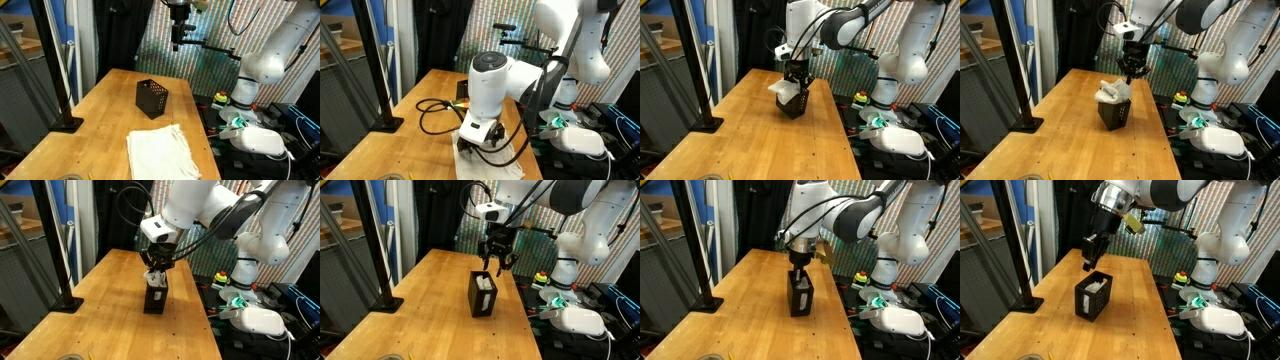
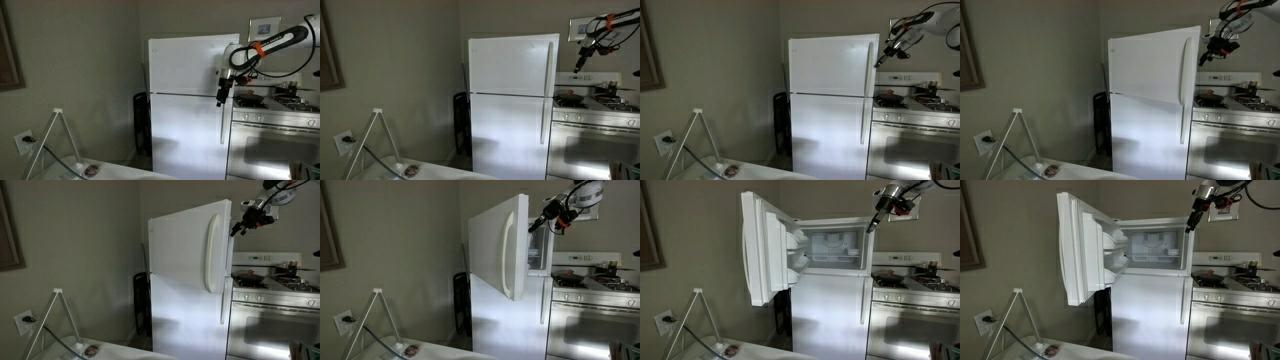
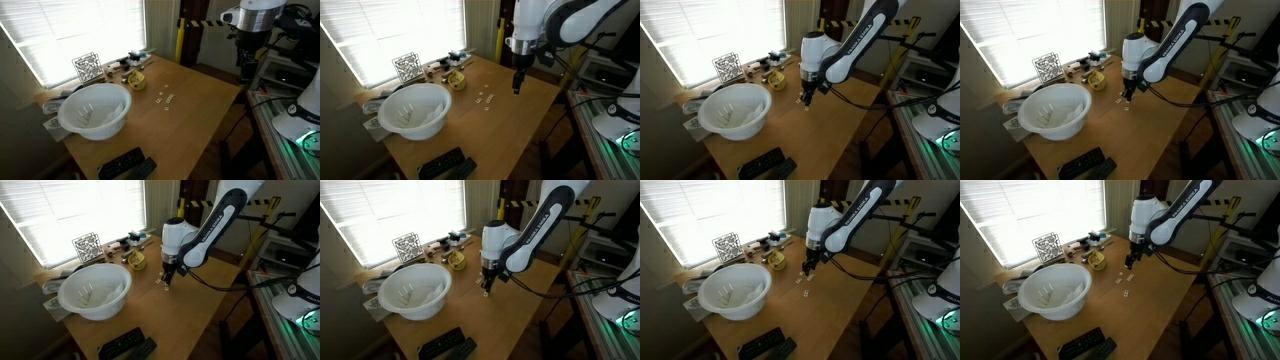
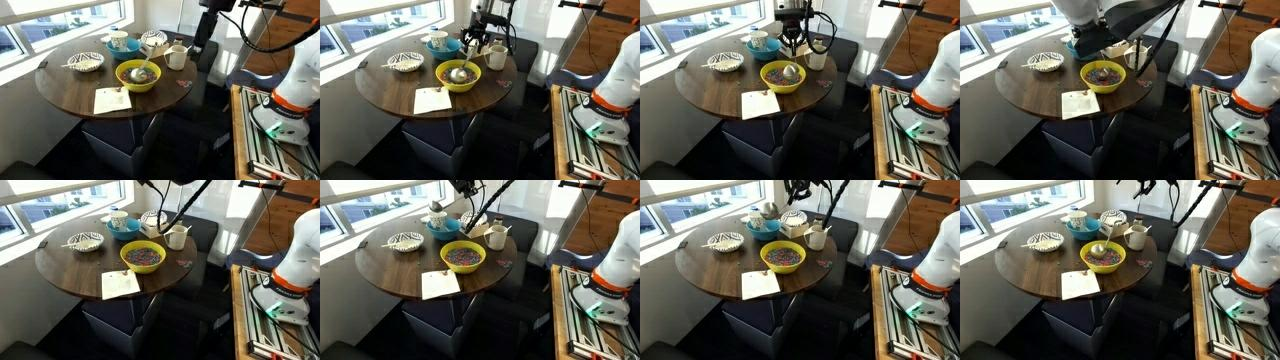

In [12]:
def render_inline(image):
    image = jax.device_get(image)
    image = np.array(image)

    if image.dtype == np.float32:
        image = ((image + 1.0) * 127.5).clip(0, 255).astype(np.uint8)

    image = image.squeeze()  # Remove singleton dims like (1, 1, 3)

    image = Image.fromarray(image)

    with io.BytesIO() as buffer:
        image.save(buffer, format='jpeg')
        encoded = base64.b64encode(buffer.getvalue()).decode('utf-8')

    return f'data:image/jpeg;base64,{encoded}'




def render_example(image, caption):
    return f"""
        <div style="display: inline-flex; align-items: center; justify-content: center;">
            <img style="max-width:100%;" src="{render_inline(image)}" />
            <p style="width:256px; margin:10px; font-size:small;">{html.escape(caption)}</p>
        </div>
    """



# from IPython.display import HTML, display
# import html
# import base64

html_out = ""
for idx, example in zip(range(10), validation_data_iterator()):
    caption = postprocess_tokens(example["text"])  # detokenize model input
    caption = caption[len("caption en\n"):]        # remove prompt prefix
    html_out += render_example(example["image_raw"], caption)

display(HTML(html_out))



In [13]:
# The main update_fn using a simple stochastic gradient descent (SGD).
@functools.partial(jax.jit, donate_argnums=(0,))
def update_fn(params, batch, learning_rate):
  imgs, txts, mask_ar = batch["image"], batch["text"], batch["mask_ar"]

  def loss_fn(params):
    text_logits, _ = model.apply({"params": params}, imgs, txts[:, :-1], mask_ar[:, :-1], train=True)
    logp = jax.nn.log_softmax(text_logits, axis=-1)

    # The model takes as input txts[:, :-1] but the loss is defined as predicting
    # next tokens txts[:, 1:]. Additionally, mask_loss[:, 1:] indicates which tokens
    # are part of the loss (e.g. prefix and padded tokens are not included).
    mask_loss = batch["mask_loss"][:, 1:]
    targets = jax.nn.one_hot(txts[:, 1:], text_logits.shape[-1])

    # Compute the loss per example. i.e. the mean of per token pplx.
    # Since each example has a different number of tokens, normalize it.
    token_pplx = jnp.sum(logp * targets, axis=-1)  # sum across vocab_size.
    example_loss = -jnp.sum(token_pplx * mask_loss, axis=-1)  # sum across seq_len.
    example_loss /= jnp.clip(jnp.sum(mask_loss, -1), 1)  # weight by num of tokens.

    # batch_loss: mean of per example loss.
    return jnp.mean(example_loss)

  loss, grads = jax.value_and_grad(loss_fn)(params)

  # Apply gradients to trainable params using SGD.
  def apply_grad(param, gradient, trainable):
    if not trainable: return param
    return param - learning_rate * gradient

  params = jax.tree_util.tree_map(apply_grad, params, grads, trainable_mask)

  return params, loss

# Evaluation/inference loop.
def make_predictions(data_iterator, *, num_examples=None,
                     batch_size=4, seqlen=SEQLEN, sampler="greedy"):
  outputs = []
  while True:
    # Construct a list of examples in the batch.
    examples = []
    try:
      for _ in range(batch_size):
        examples.append(next(data_iterator))
        examples[-1]["_mask"] = np.array(True)  # Indicates true example.
    except StopIteration:
      if len(examples) == 0:
        return outputs

    # Not enough examples to complete a batch. Pad by repeating last example.
    while len(examples) % batch_size:
      examples.append(dict(examples[-1]))
      examples[-1]["_mask"] = np.array(False)  # Indicates padding example.

    # Convert list of examples into a dict of np.arrays and load onto devices.
    batch = jax.tree.map(lambda *x: np.stack(x), *examples)
    batch = big_vision.utils.reshard(batch, data_sharding)

    # Make model predictions
    tokens = decode({"params": params}, batch=batch,
                    max_decode_len=seqlen, sampler=sampler)

    # Fetch model predictions to device and detokenize.
    tokens, mask = jax.device_get((tokens, batch["_mask"]))
    tokens = tokens[mask]  # remove padding examples.
    responses = [postprocess_tokens(t) for t in tokens]

    # Append to html output.
    for example, response in zip(examples, responses):
      outputs.append((example["image"], response))
      if num_examples and len(outputs) >= num_examples:
        return outputs

## Tune the model

Now that you've set everything up and taken a look at the training data, it's time to finally tune the model. The code below runs the training loop for the model for 64 steps and prints the learning rate (`lr` in the printed output) and loss rate for each step.

Every 16 steps, the model prints what its predictions are at that step in the training. This code prints out predictions for the same set of images so that you can see the model's ability to predict descriptions improve over time.

At earlier steps in the training, there's likely issues with the descriptions, such as repeated sentences as the model gets stuck in its predictive loop or unfinished sentences. The model's predictions become steadily more accurate as training progresses. By step 64, the model's predictions should closely resemble the descriptions provided by the training data.

This process takes around 15 minutes to complete on T4 TPUs.

b'Move the green plush to the left'
b''
b''
b''
b'Put the middle fork in the middle section of the white object'
[    2 21209   659   108  2931   573  4433 47731   577   573  2731     1
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
step:  1/64   lr: 0.00500   loss: 4.2643
Model predictions at step 1
b''
b'Put the yellow cube inside the blue cup'
b'Move the pot to the top left corner of the table'
b'Move the faucet to the center of the sink'
b''
b''
b'Get the marker from the table and place it in the colorless cup'
b'Pick the two bottles on the stove and place them on the counter, then pick the cooking stick from the pot and place it on the stove'
b'Take the blocks out of the gift disappointed'
b''
Caption the new chair in the middle
Caption the white object in the middle is the object of interest
Caption the table is the same as the other one .
Caption the table is set for the first of the day



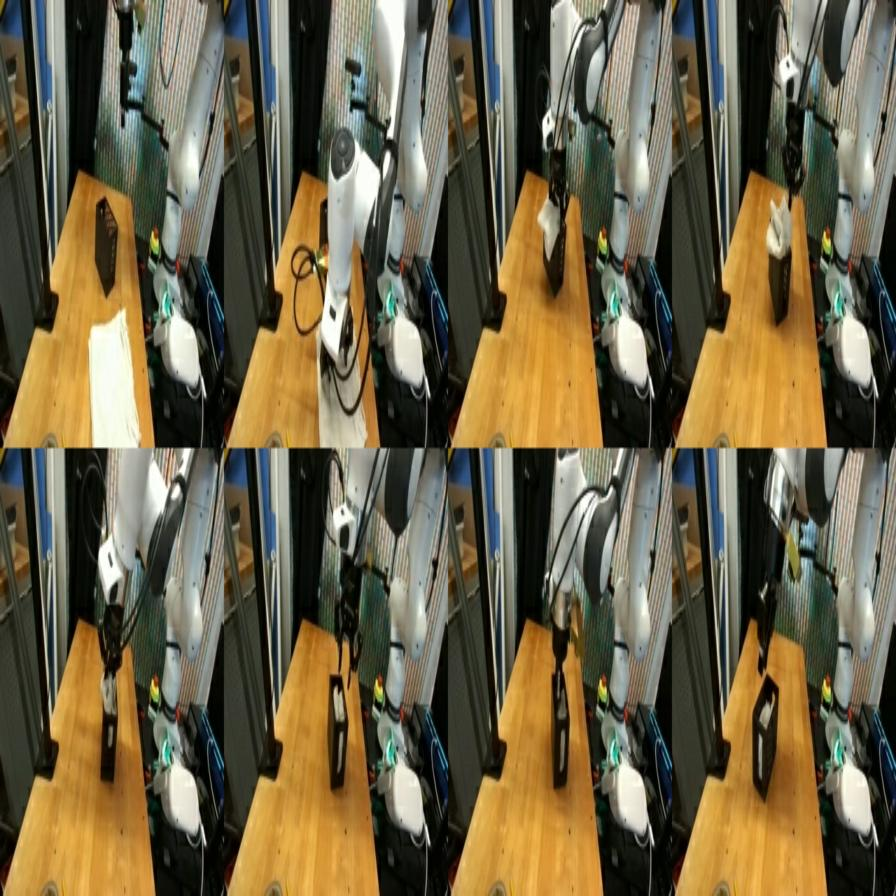
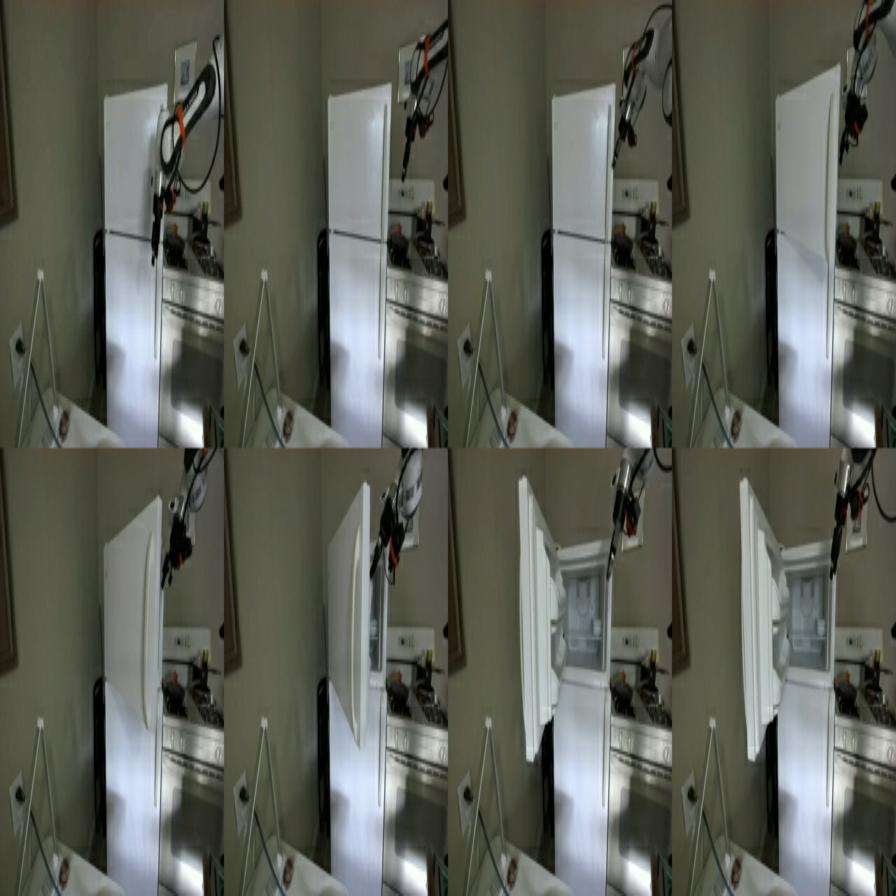
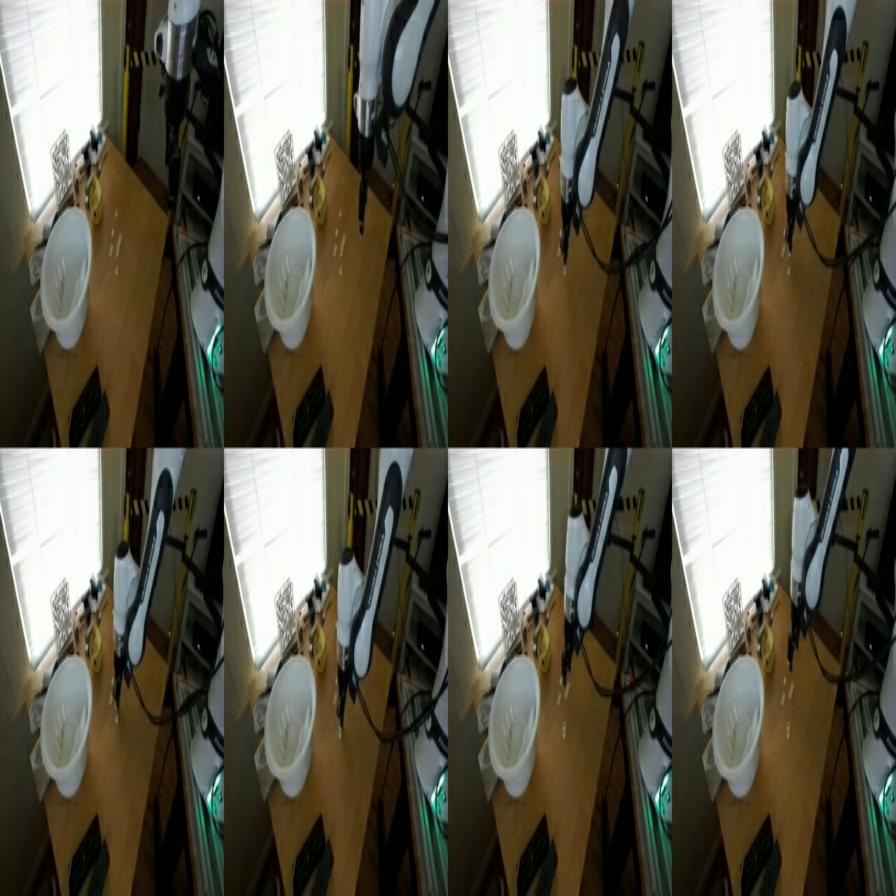
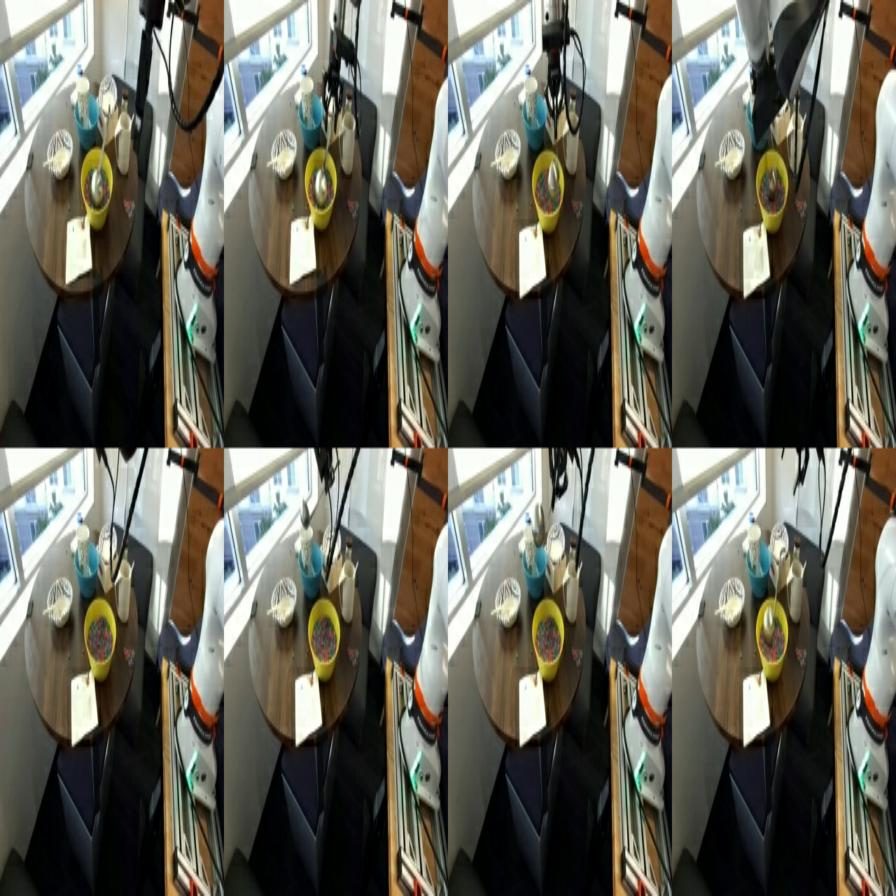

✅ Saved checkpoint to: checkpoints/checkpoint_image_unfrozen_0001.msgpack
b''
b'Put the towel on the table into the box'
b''
b''
b'Take the lid off the smaller pot'
[    2 21209   659   108  1065   573 34393   611   573  3037  1280   573
  3741     1     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
step:  2/64   lr: 0.01000   loss: 3.5955
Model predictions at step 2
b''
b'Put the yellow cube inside the blue cup'
b'Move the pot to the top left corner of the table'
b'Move the faucet to the center of the sink'
b''
b''
b'Get the marker from the table and place it in the colorless cup'
b'Pick the two bottles on the stove and place them on the counter, then pick the cooking stick from the pot and place it on the stove'
b'Take the blocks out of the gift disappointed'
b''
Caption put the lid on the lid
Caption put the lid on the lid
Caption put the lid on the lid
Caption put the lid on the lid



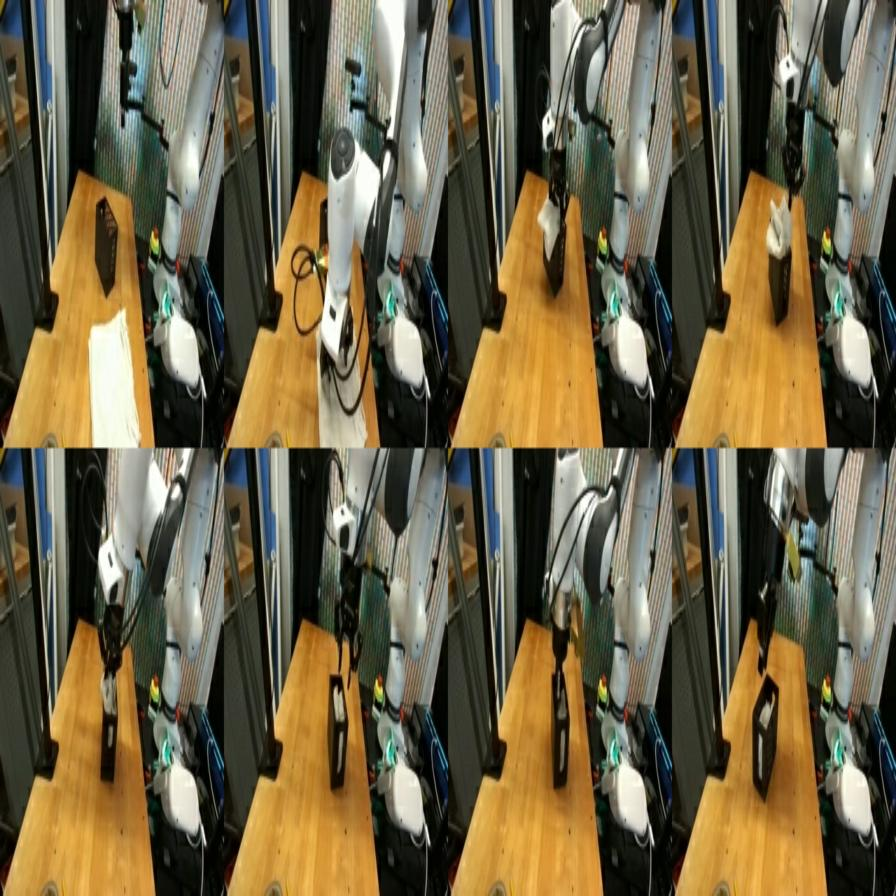
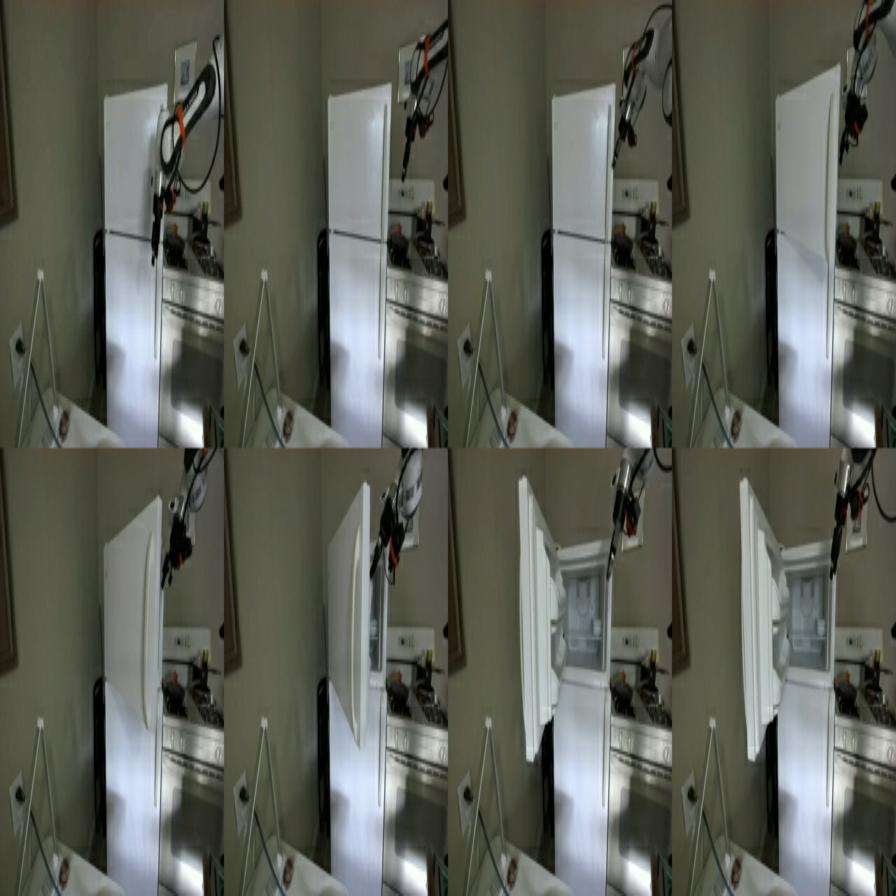
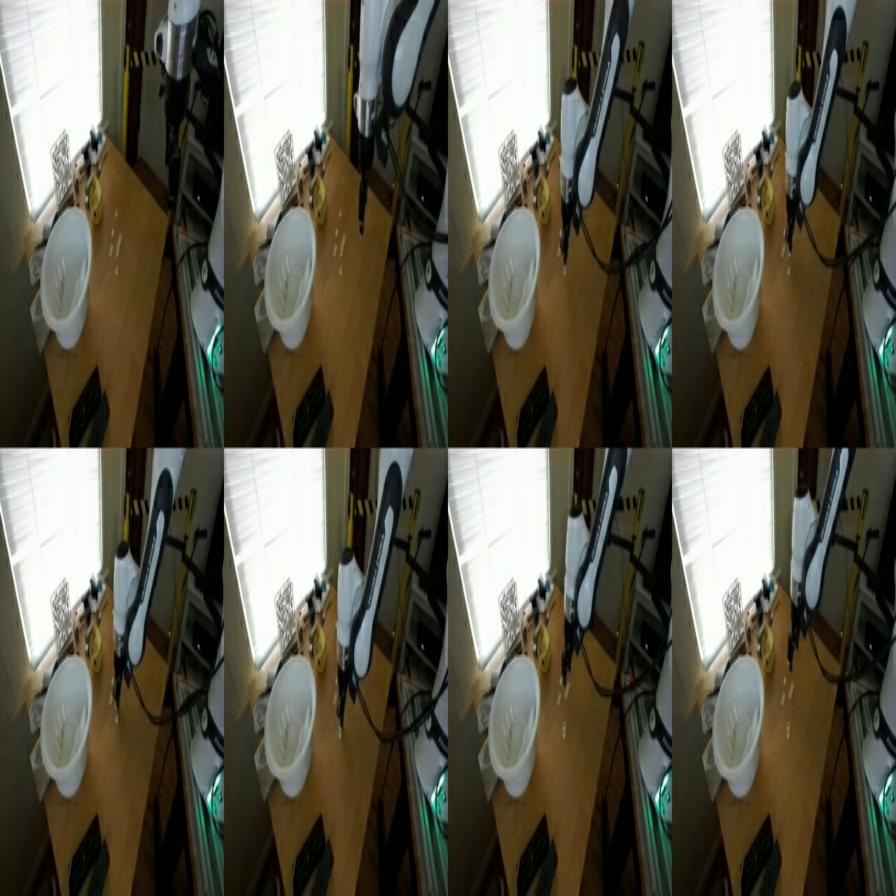
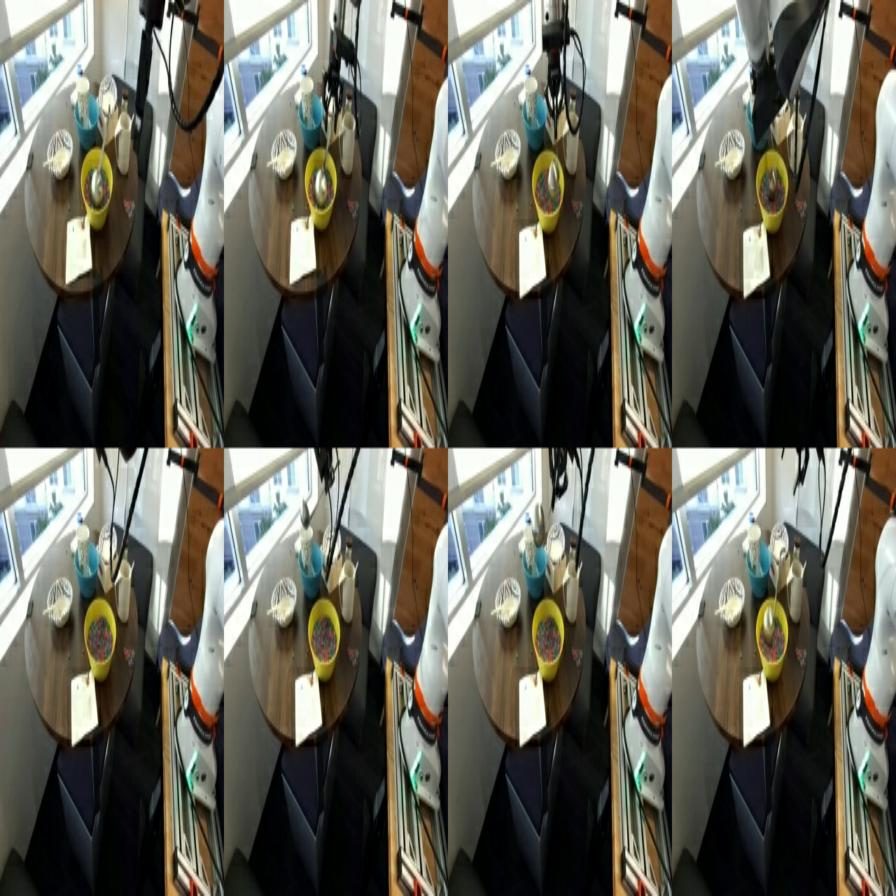

✅ Saved checkpoint to: checkpoints/checkpoint_image_unfrozen_0002.msgpack
b''
b''
b''
b'Put the marker in the pot'
b''
b''
b'move one white object from the right heap to the left, then get the blue-white object and fold it on top of the left heap'
[    2 21209   659   108  1065   573 24416   575   573  2688     1     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
step:  3/64   lr: 0.01500   loss: 3.1056
Model predictions at step 3
b''
b'Put the yellow cube inside the blue cup'
b'Move the pot to the top left corner of the table'
b'Move the faucet to the center of the sink'
b''
b''
b'Get the marker from the table and place it in the colorless cup'
b'Pick the two bottles on the stove and place them on the counter, then pick the cooking stick from the pot and place it on the stove'
b'Take the blocks out of the gift disappointed'
b''
Caption put the object in the pot
Caption put the object in the pot
Caption put t


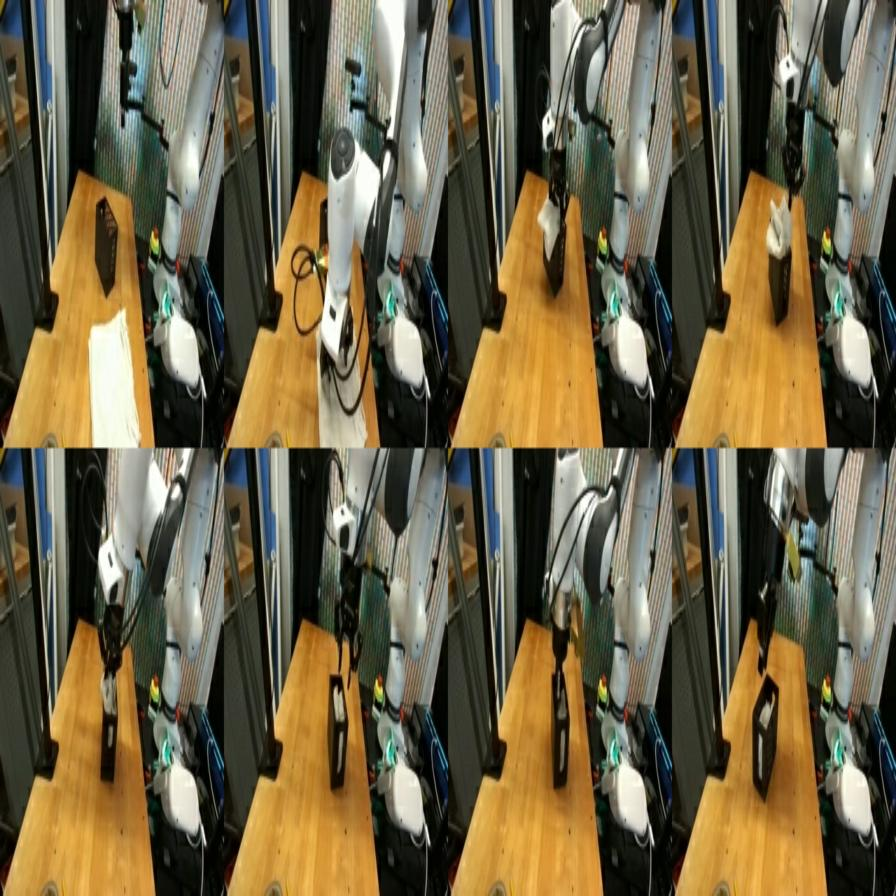
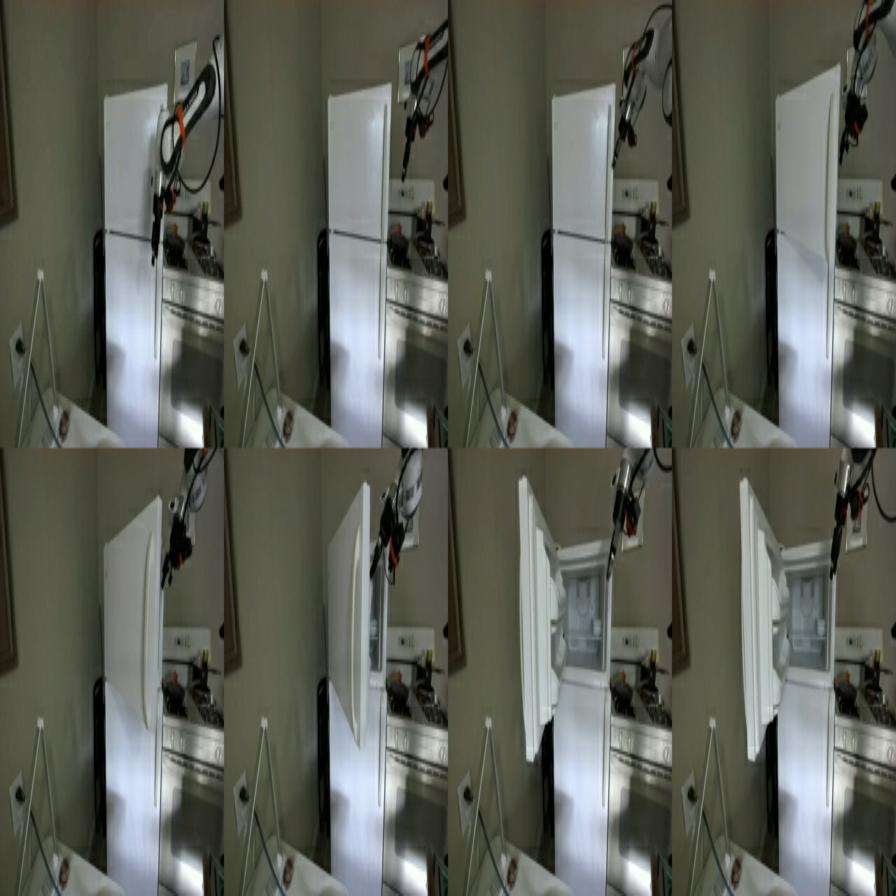
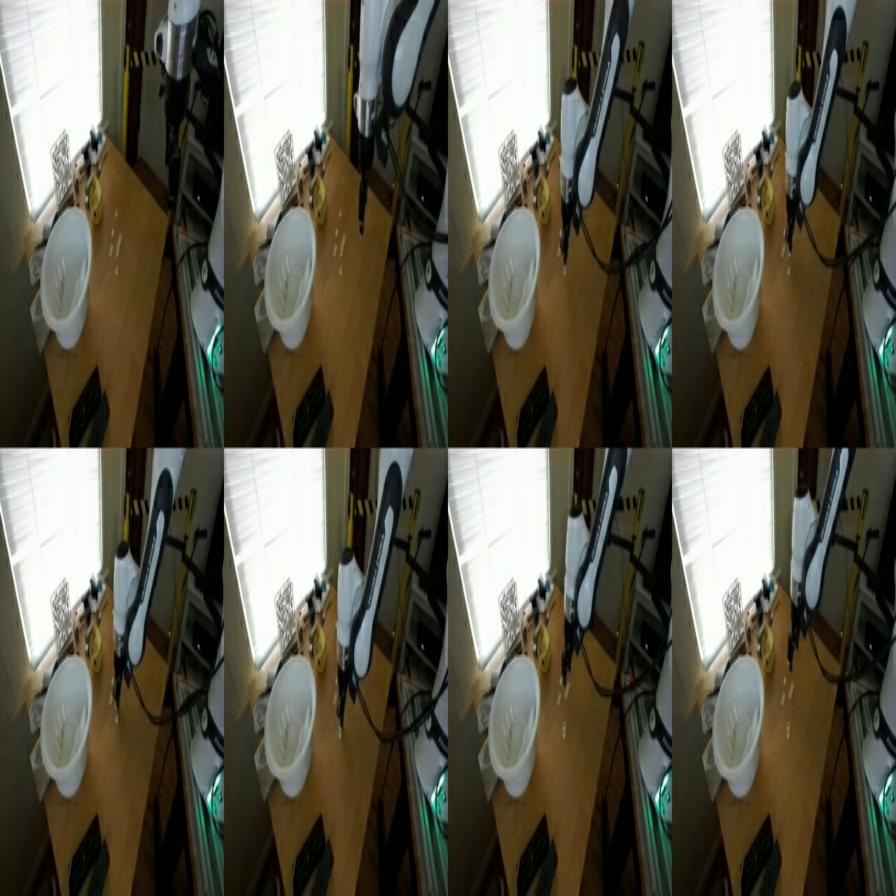
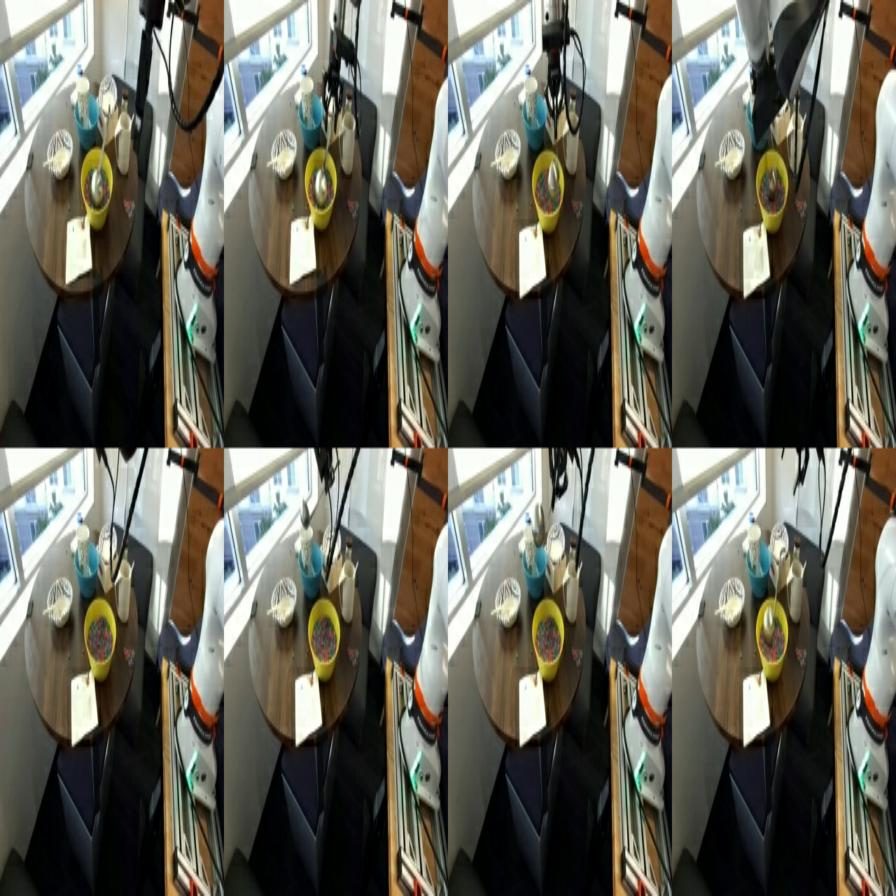

✅ Saved checkpoint to: checkpoints/checkpoint_image_unfrozen_0003.msgpack
b''
b''
b''
b'Put the tissues in the rubbish bin.'
b''
b'Move the sharpie to the table'
[     2  21209    659    108   1065    573  29703    575    573  68907
   8881 235265      1      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0]
step:  4/64   lr: 0.02000   loss: 3.3086
Model predictions at step 4
b''
b'Put the yellow cube inside the blue cup'
b'Move the pot to the top left corner of the table'
b'Move the faucet to the center of the sink'
b''
b''
b'Get the marker from the table and place it in the colorless cup'
b'Pick the two bottles on the stove and place them on the counter, then pick the cooking stick from the pot and place it on the stove'
b'Take the blocks out of the gift disappointed'
b''
Caption put the tissue in the trash.
Caption put the tissue in the trash.
Caption put the tissue in the trash.
Caption put the tissue 


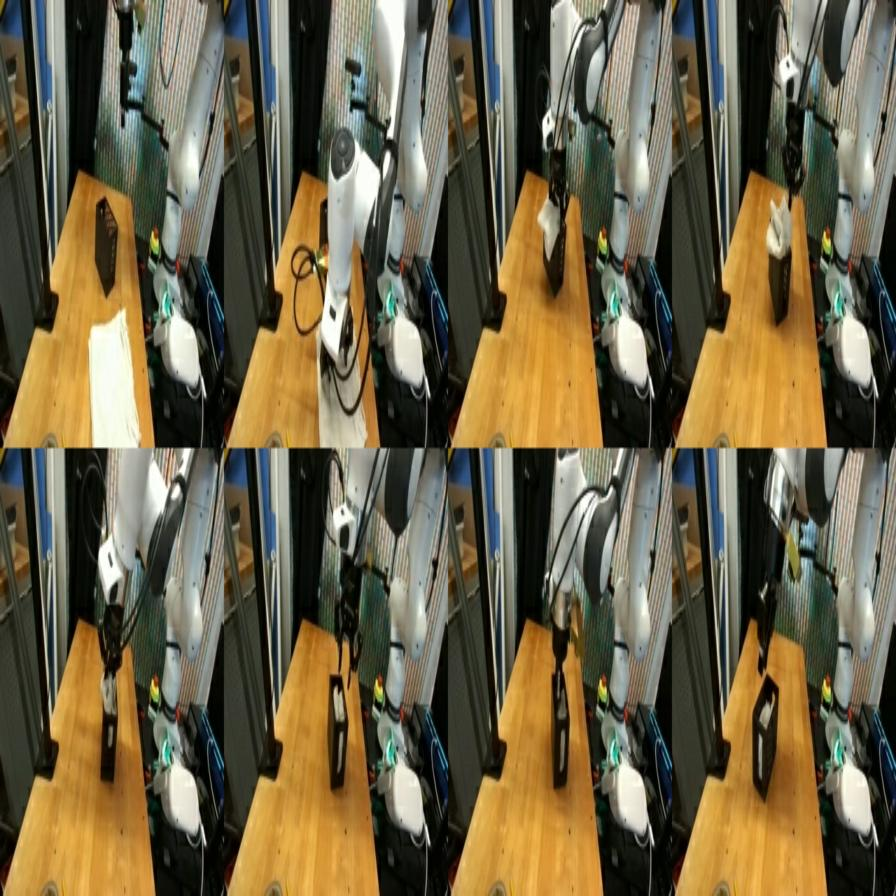
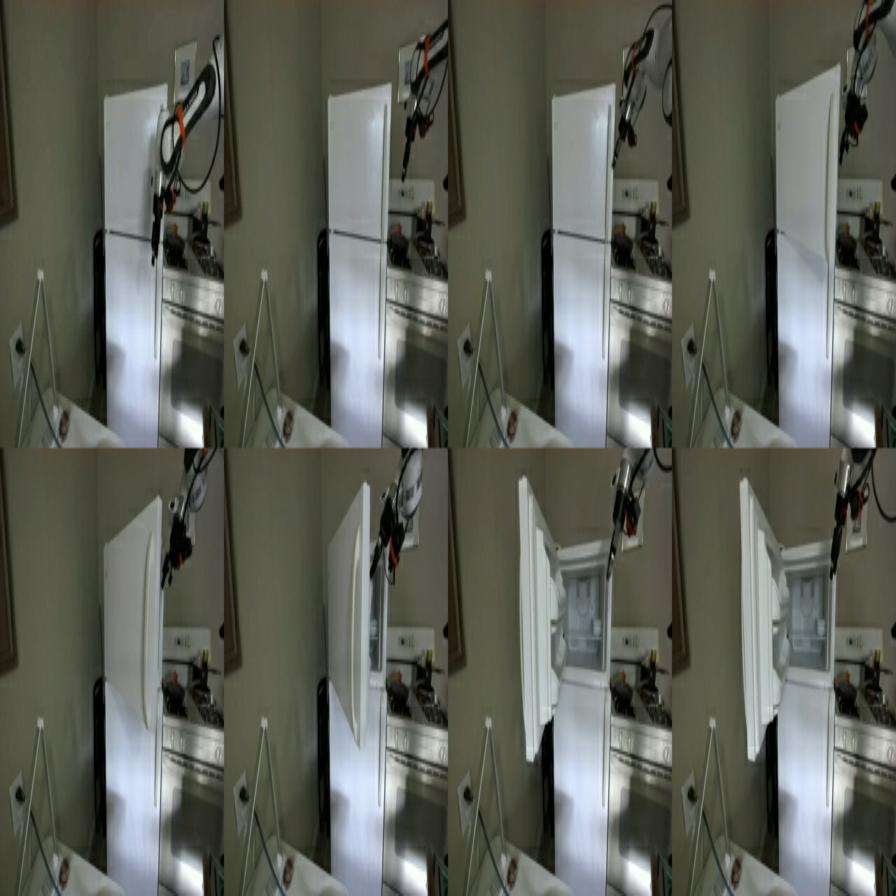
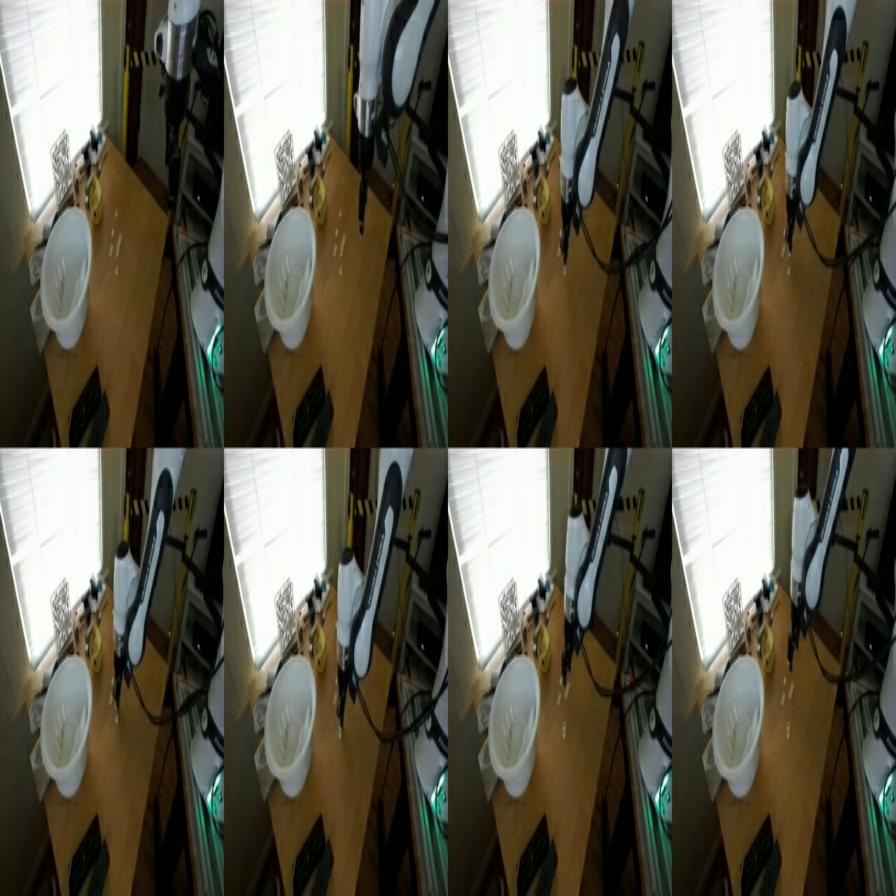
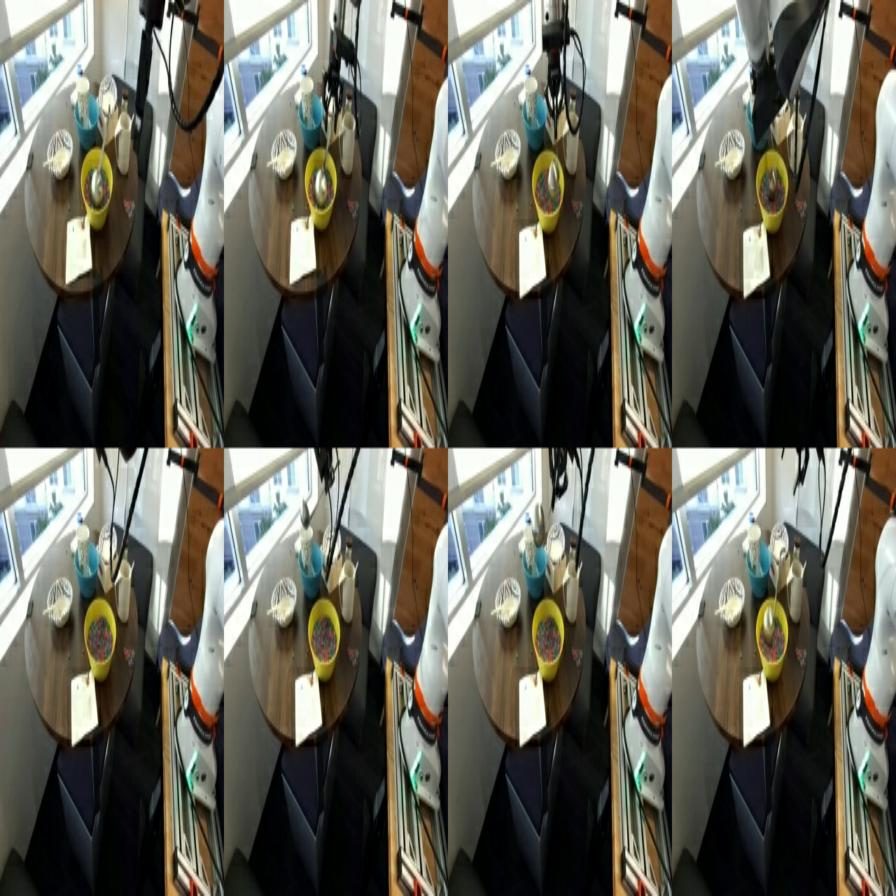

✅ Saved checkpoint to: checkpoints/checkpoint_image_unfrozen_0004.msgpack
b'Press a button on the keyboard'
b''
b'Pick up the lid from the table and put it on the pot'
[    2 21209   659   108 11355   476  6086   611   573 20434     1     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
step:  5/64   lr: 0.02500   loss: 3.2765
Model predictions at step 5
b''
b'Put the yellow cube inside the blue cup'
b'Move the pot to the top left corner of the table'
b'Move the faucet to the center of the sink'
b''
b''
b'Get the marker from the table and place it in the colorless cup'
b'Pick the two bottles on the stove and place them on the counter, then pick the cooking stick from the pot and place it on the stove'
b'Take the blocks out of the gift disappointed'
b''
Caption press a button on a keyboard
Caption press a button on a keyboard
Caption press a button on a keyboard
Caption press a button on a keyboard



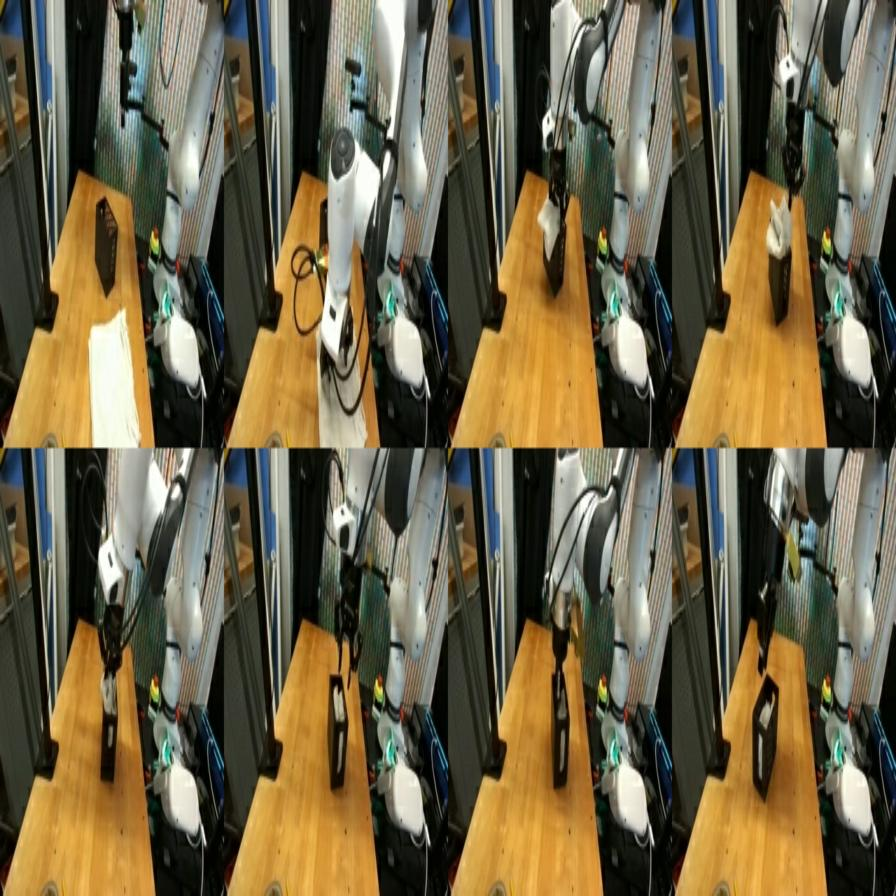
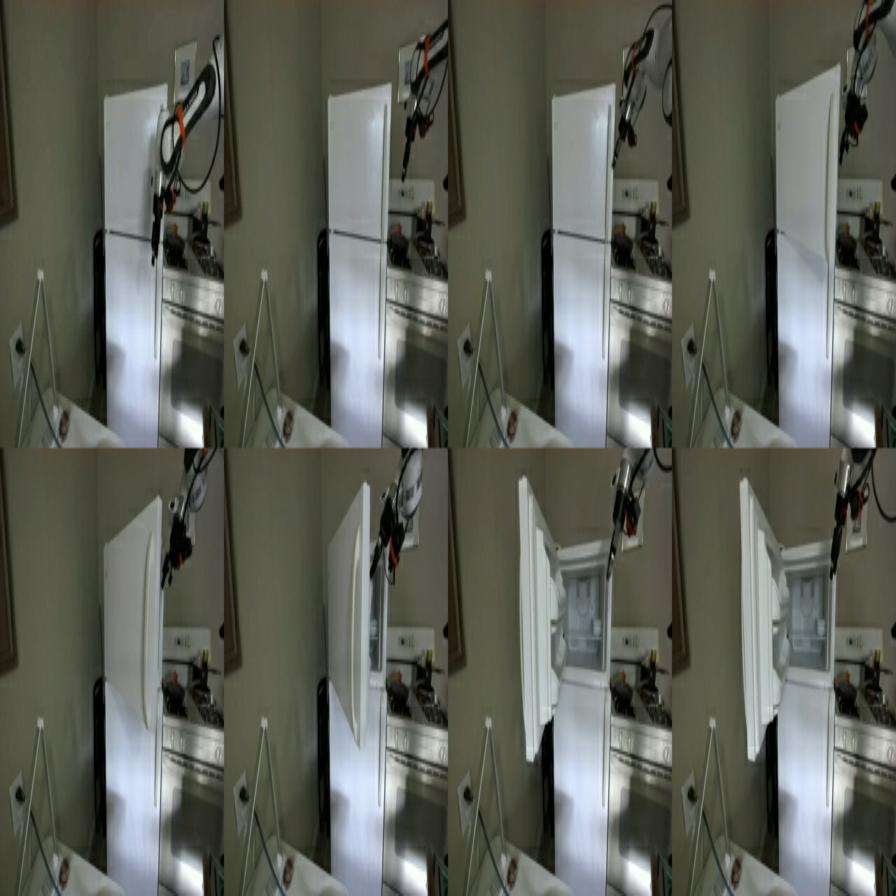
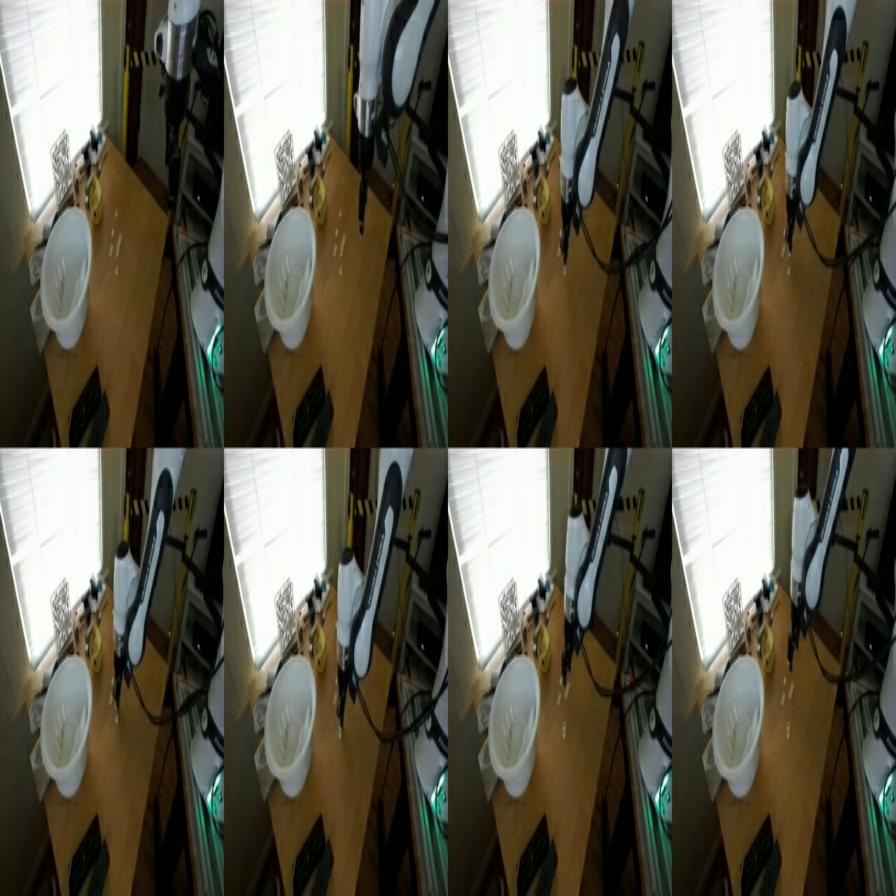
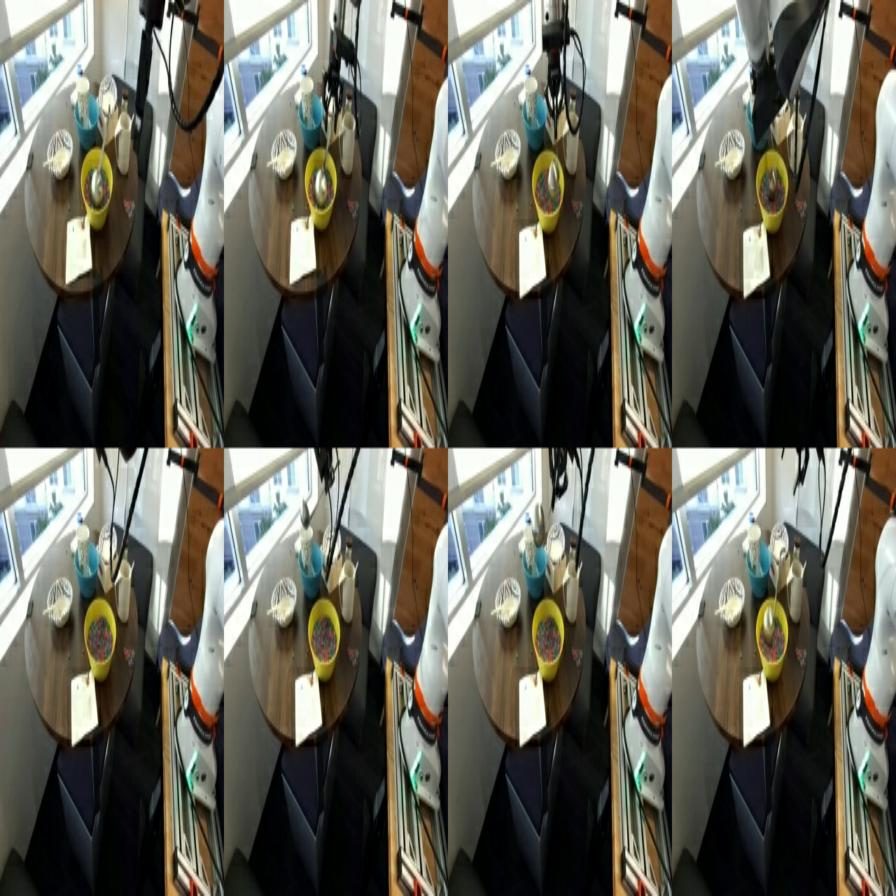

✅ Saved checkpoint to: checkpoints/checkpoint_image_unfrozen_0005.msgpack
b''
b''
b''
b'Move the pan to the right.'
b'Put the objects on the table into the cardboard box'
[     2  21209    659    108   2931    573   2959    577    573   1833
 235265      1      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0]
step:  6/64   lr: 0.03000   loss: 3.5232
Model predictions at step 6
b''
b'Put the yellow cube inside the blue cup'
b'Move the pot to the top left corner of the table'
b'Move the faucet to the center of the sink'
b''
b''
b'Get the marker from the table and place it in the colorless cup'
b'Pick the two bottles on the stove and place them on the counter, then pick the cooking stick from the pot and place it on the stove'
b'Take the blocks out of the gift disappointed'
b''
Caption move the pan to the right.
Caption move the pan to the right.
Caption move the pan to the right.
Caption move the pan


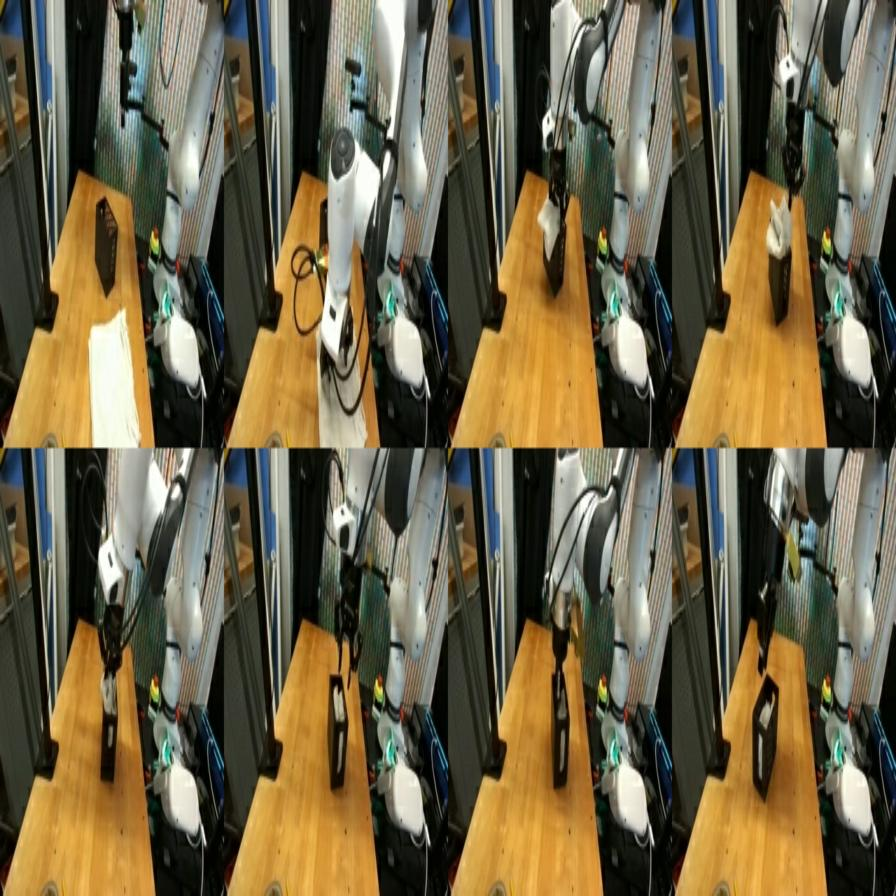
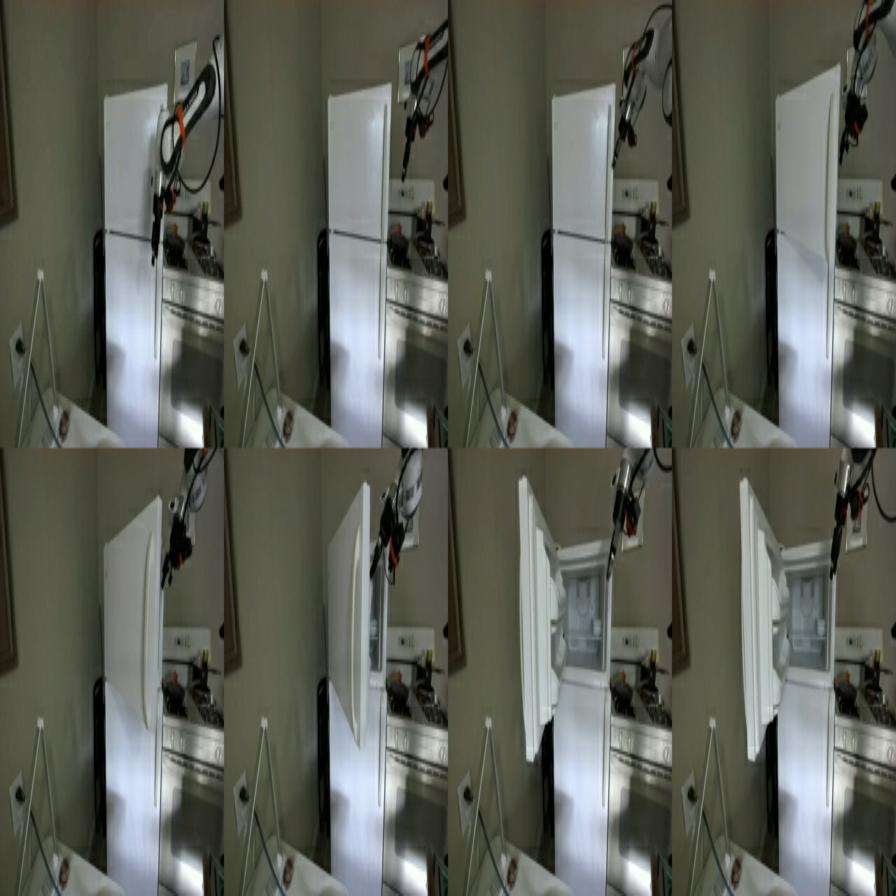
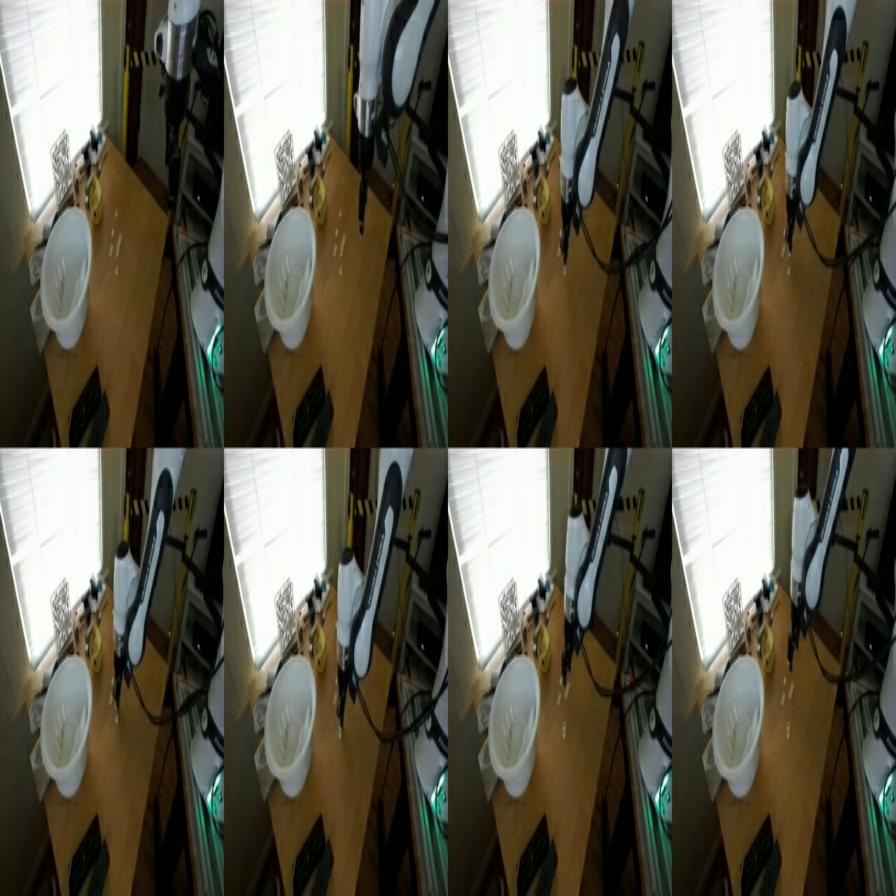
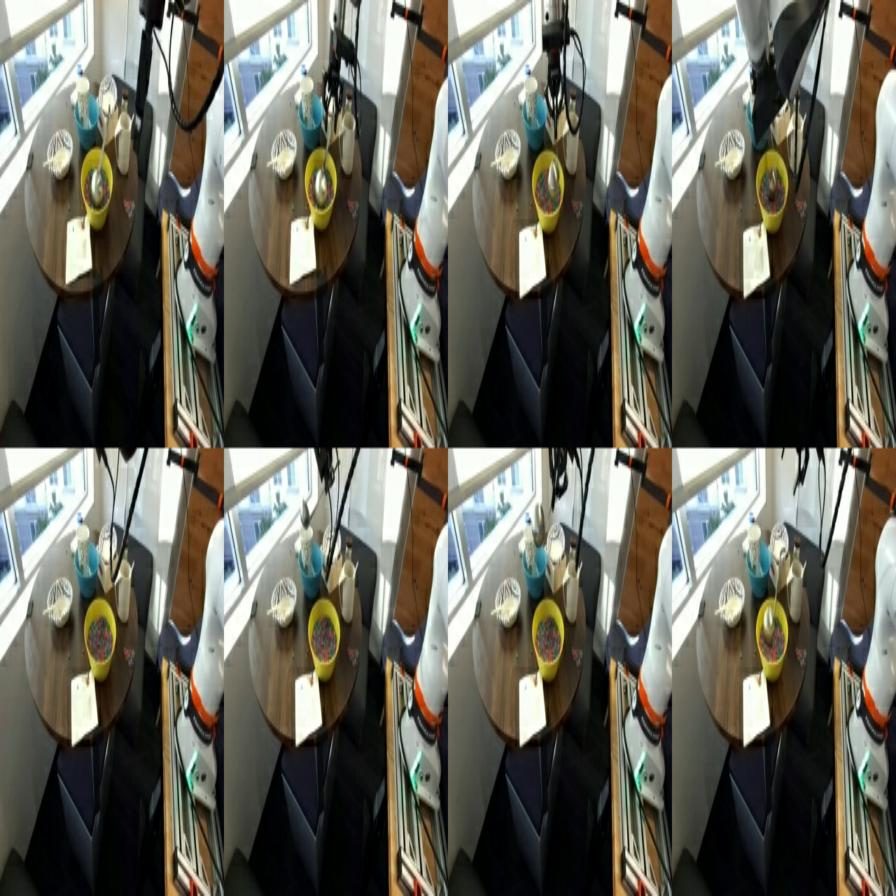

✅ Saved checkpoint to: checkpoints/checkpoint_image_unfrozen_0006.msgpack
b'Put the marker inside the cup'
b'Pick up the black object from the striped towel and place it on the white sheet of paper on the right'
[    2 21209   659   108  1065   573 24416  5580   573  7190     1     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
step:  7/64   lr: 0.02998   loss: 2.8541
Model predictions at step 7
b''
b'Put the yellow cube inside the blue cup'
b'Move the pot to the top left corner of the table'
b'Move the faucet to the center of the sink'
b''
b''
b'Get the marker from the table and place it in the colorless cup'
b'Pick the two bottles on the stove and place them on the counter, then pick the cooking stick from the pot and place it on the stove'
b'Take the blocks out of the gift disappointed'
b''
Caption put the marker inside the cup
Caption put the marker inside the cup
Caption put the marker inside the cup
Cap


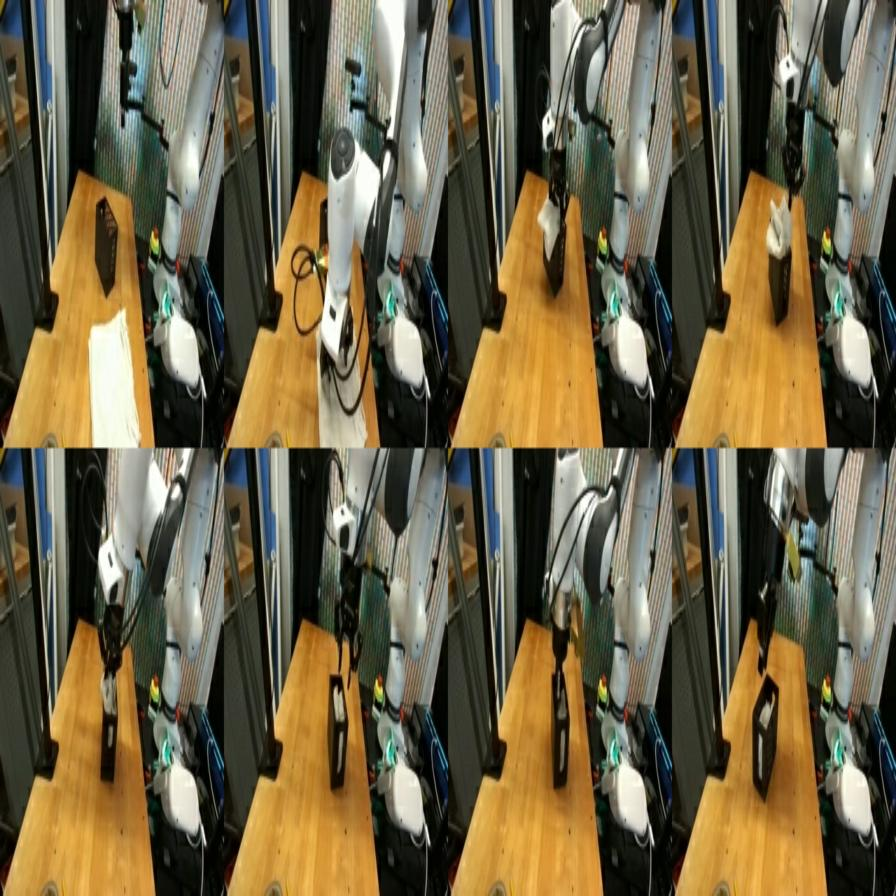
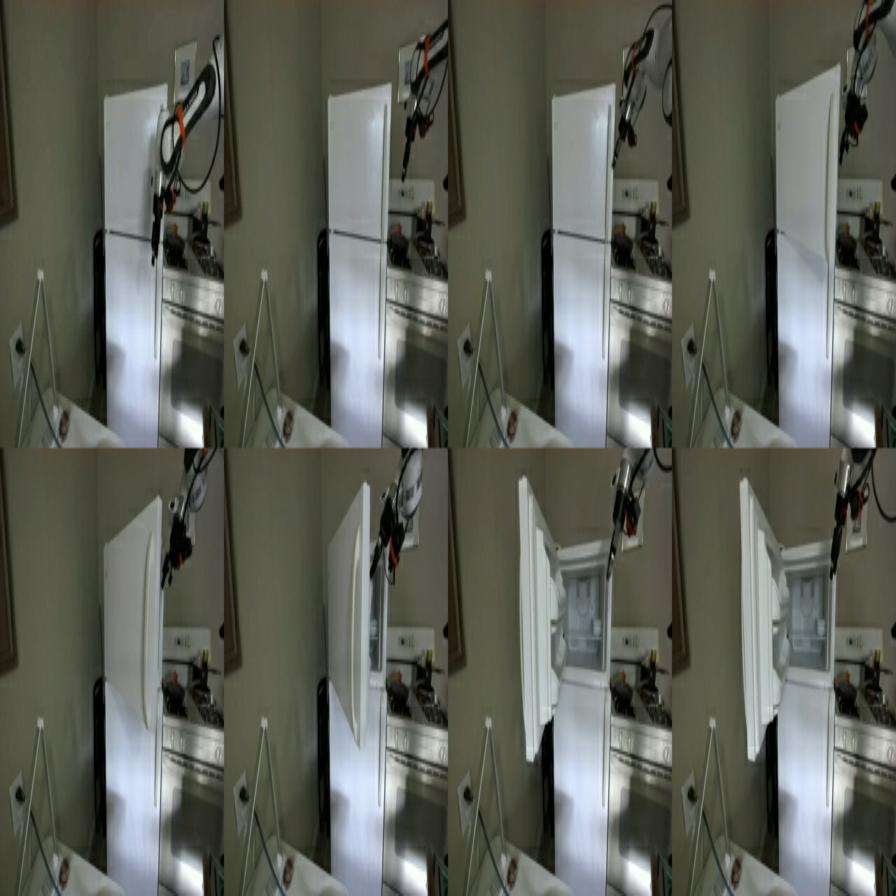
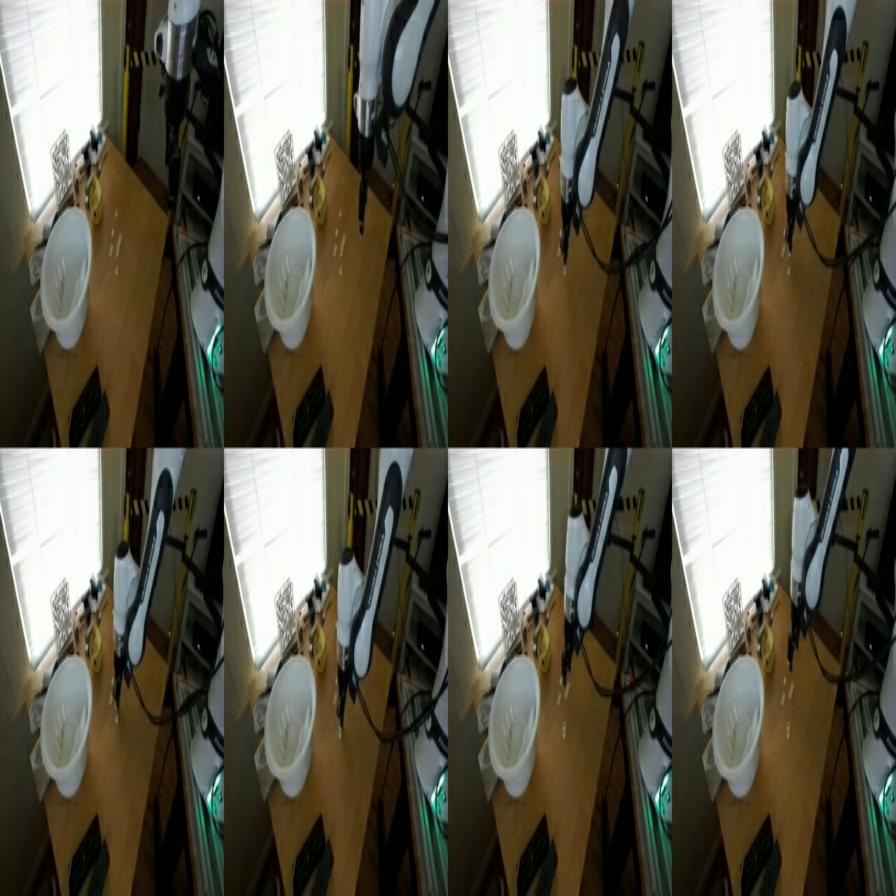
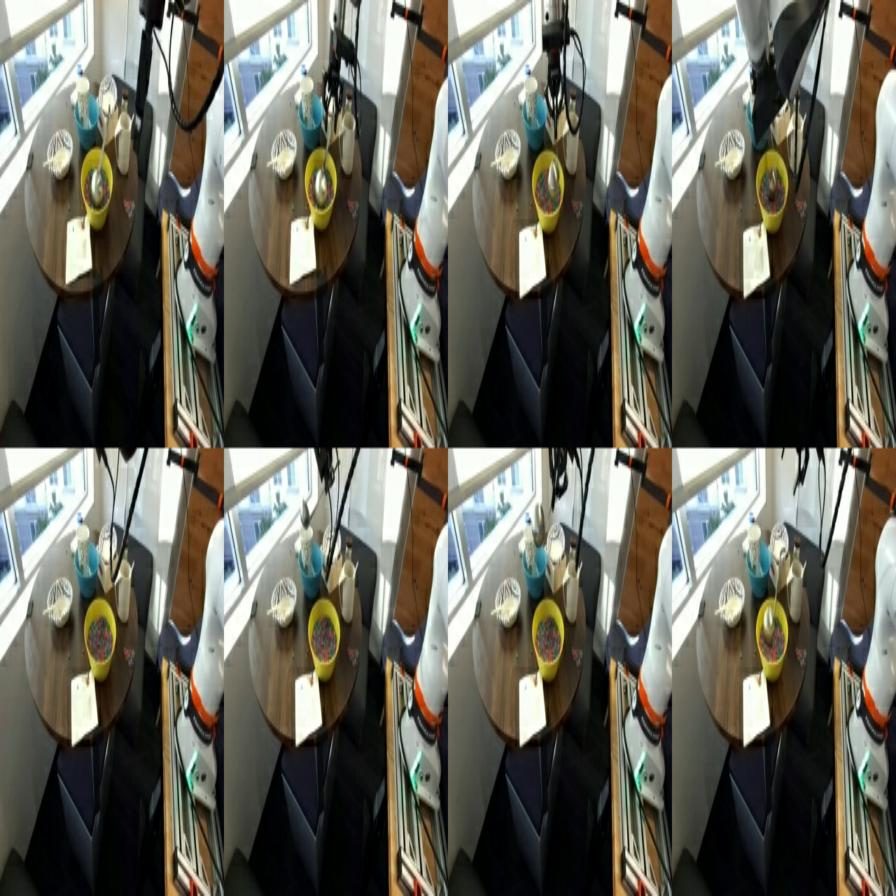

✅ Saved checkpoint to: checkpoints/checkpoint_image_unfrozen_0007.msgpack
b'Put the  cable in the storage box'
b'Move the glass to the second row in the dishwasher'
[    2 21209   659   108  1065   573   139 26812   575   573  7387  3741
     1     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
step:  8/64   lr: 0.02992   loss: 3.7581
Model predictions at step 8
b''
b'Put the yellow cube inside the blue cup'
b'Move the pot to the top left corner of the table'
b'Move the faucet to the center of the sink'
b''
b''
b'Get the marker from the table and place it in the colorless cup'
b'Pick the two bottles on the stove and place them on the counter, then pick the cooking stick from the pot and place it on the stove'
b'Take the blocks out of the gift disappointed'
b''
Caption put the object in the box
Caption put the object in the box
Caption put the object in the box
Caption put the object in the box



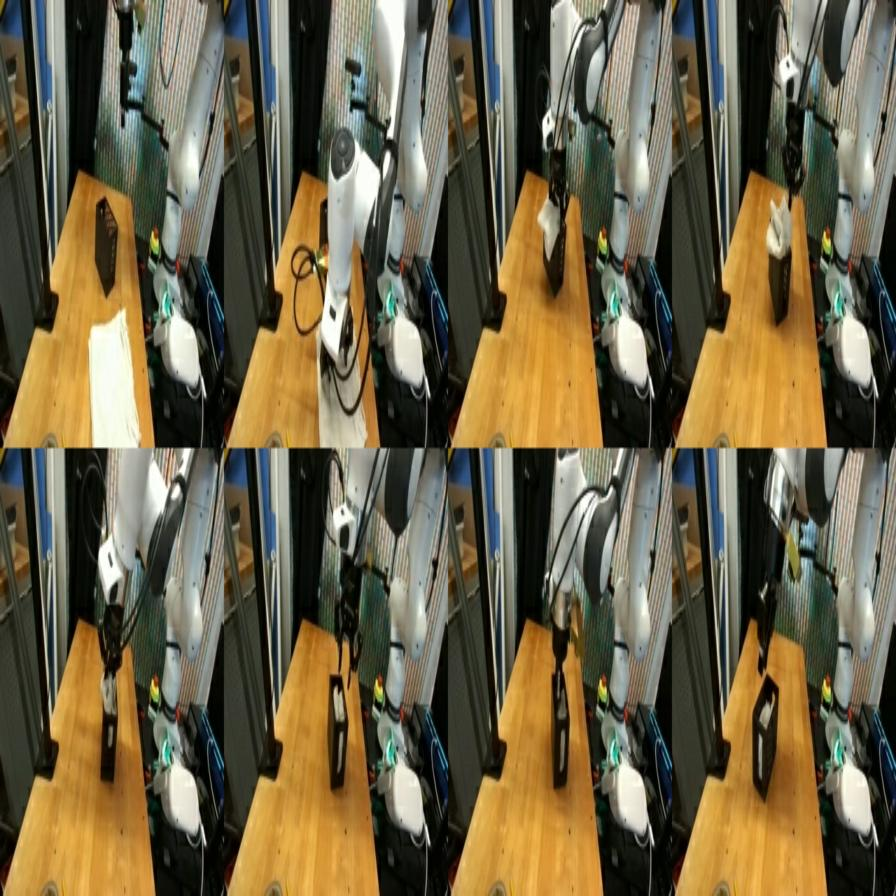
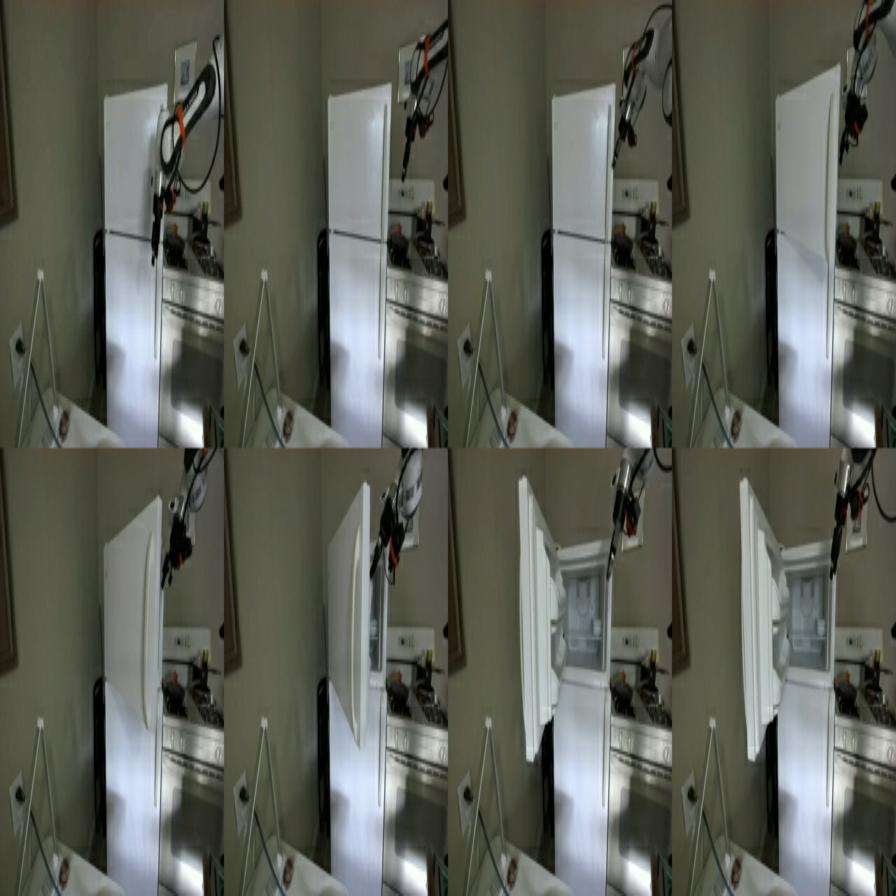
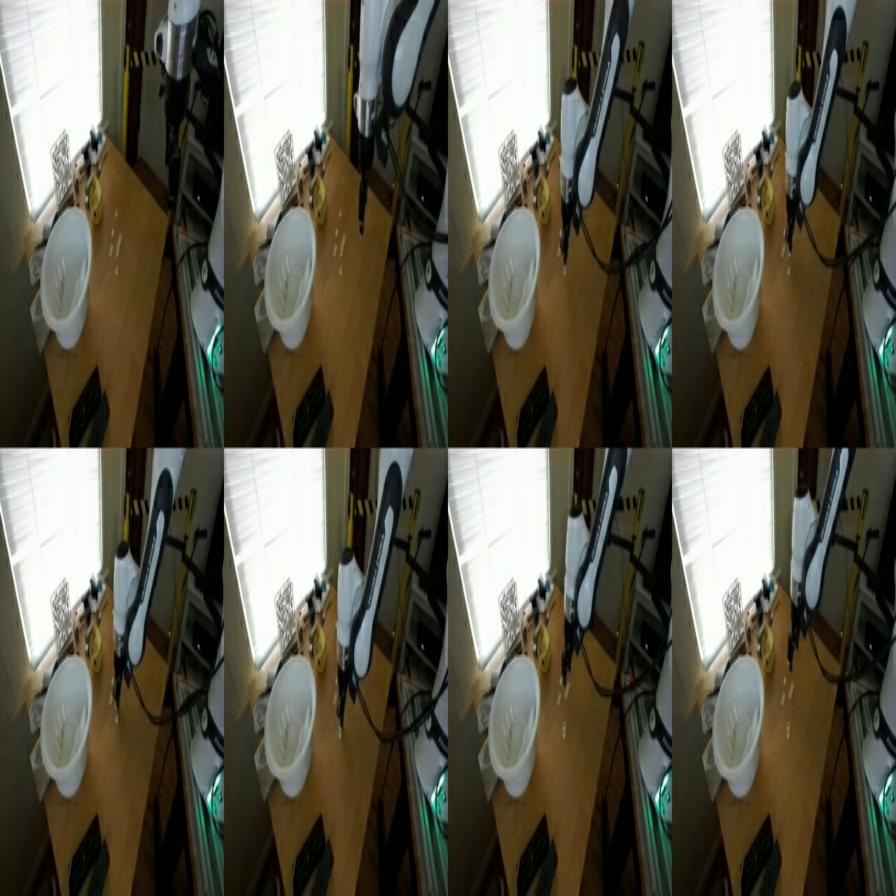
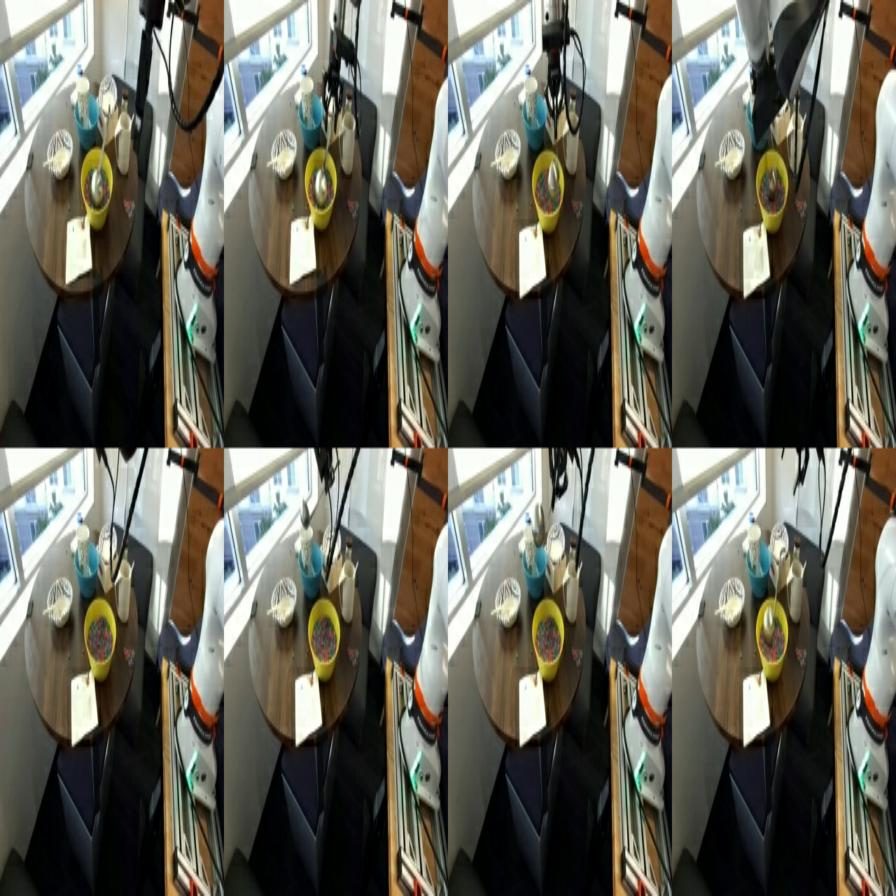

✅ Saved checkpoint to: checkpoints/checkpoint_image_unfrozen_0008.msgpack
b''
b''
b'Move the cup to the right'
b''
b''
b'Use the duster to wipe the whiteboard'
[    2 21209   659   108  2931   573  7190   577   573  1833     1     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
step:  9/64   lr: 0.02981   loss: 2.5814
Model predictions at step 9
b''
b'Put the yellow cube inside the blue cup'
b'Move the pot to the top left corner of the table'
b'Move the faucet to the center of the sink'
b''
b''
b'Get the marker from the table and place it in the colorless cup'
b'Pick the two bottles on the stove and place them on the counter, then pick the cooking stick from the pot and place it on the stove'
b'Take the blocks out of the gift disappointed'
b''
Caption move the pan to the right
Caption move the pan to the right
Caption move the pan to the right
Caption move the pan to the right



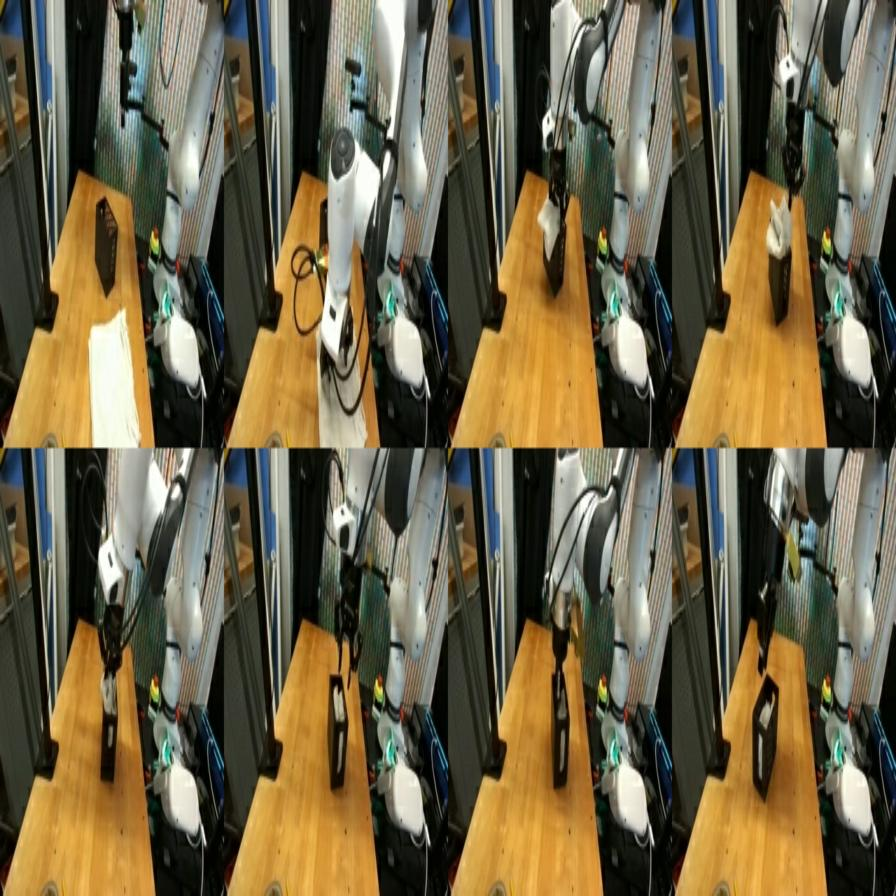
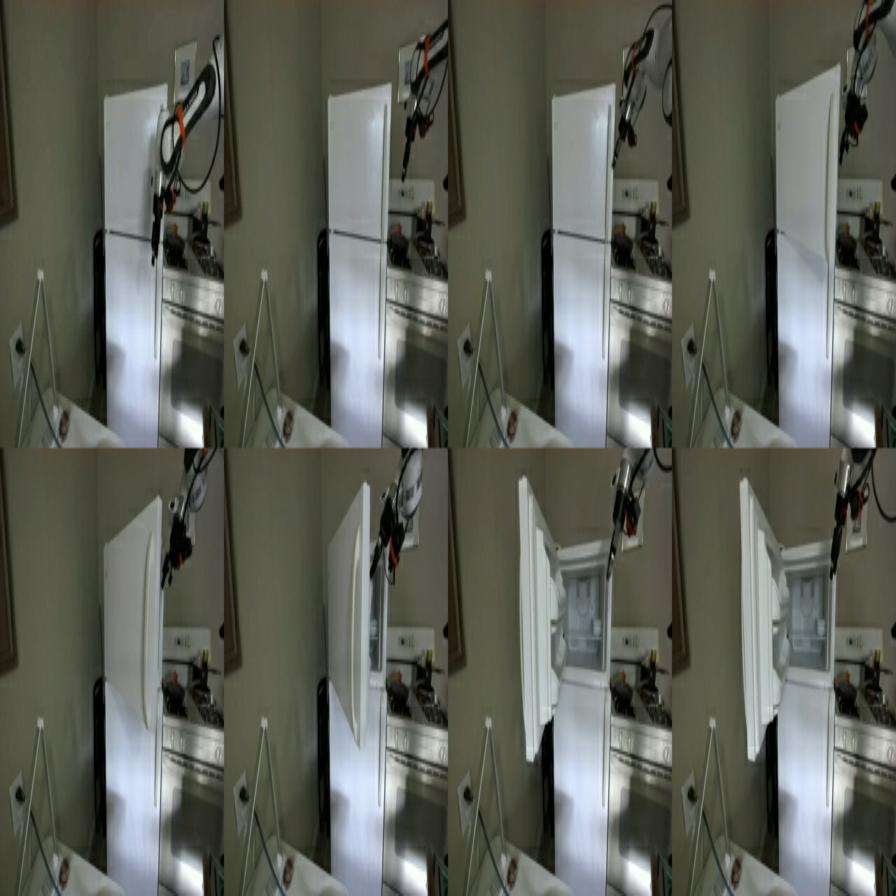
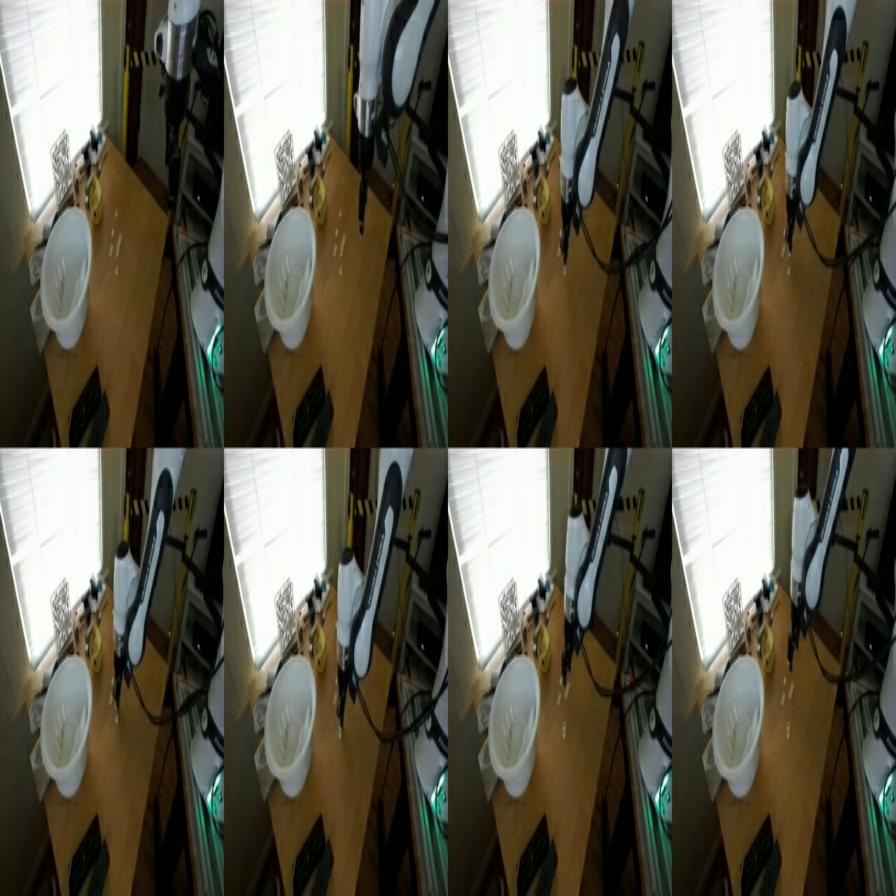
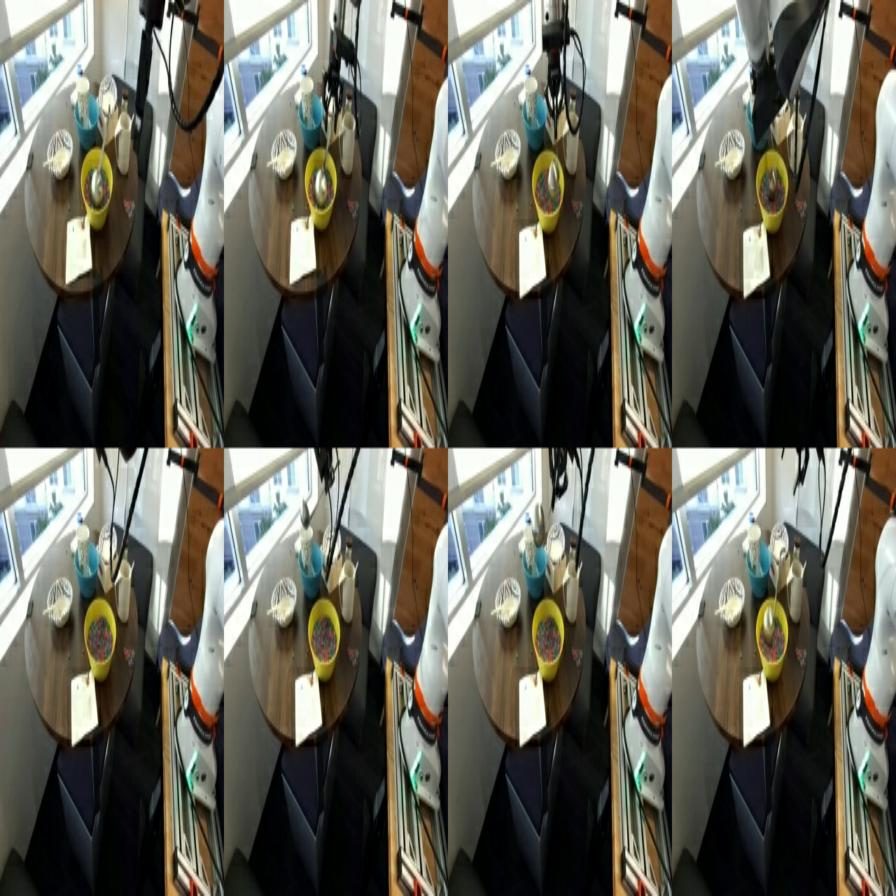

KeyboardInterrupt: 

In [14]:
# Run a short training loop with cosine learning rate schedule.
#
# Note: the first step can be quite slow on some machines (up to several minutes)
# due to XLA compilation of the jax.jit'd function.
#
# %%time

BATCH_SIZE = 2
TRAIN_EXAMPLES = 128
LEARNING_RATE = 0.03

TRAIN_STEPS = TRAIN_EXAMPLES // BATCH_SIZE
EVAL_STEPS = 1

train_data_it = train_data_iterator()

sched_fn = big_vision.utils.create_learning_rate_schedule(
    total_steps=TRAIN_STEPS+1, base=LEARNING_RATE,
    decay_type="cosine", warmup_percent=0.10)
for step in range(1, TRAIN_STEPS+1):
  # Make list of N training examples.
  examples = [next(train_data_it) for _ in range(BATCH_SIZE)]
  print(examples[0]['text'])

  # Convert list of examples into a dict of np.arrays and load onto devices.
  batch = jax.tree.map(lambda *x: np.stack(x), *examples)
  batch = big_vision.utils.reshard(batch, data_sharding)

  # Training step and report training loss
  learning_rate = sched_fn(step)
  params, loss = update_fn(params, batch, learning_rate)

  loss = jax.device_get(loss)
  print(f"step: {step:2d}/{TRAIN_STEPS:2d}   lr: {learning_rate:.5f}   loss: {loss:.4f}")

  if (step % EVAL_STEPS) == 0:
    print(f"Model predictions at step {step}")
    html_out = ""
    for image, caption in make_predictions(
        validation_data_iterator(), num_examples=4, batch_size=4):
      html_out += render_example(image, caption)
      print("Caption", caption)
    display(HTML(html_out))
    save_checkpoint(params, step)



## Output

The validation data for this notebook consists of just 10 images. In normal code, you would likely have many more data points for validation, but for this notebook, run the following code to generate descriptions for all 10 images. After tuning the model, these descriptions should be very similar in form and content coverage to the descriptions included with the training data that you looked at earlier in this notebook.

Run the below code to generate descriptions for the validation data set.

Model predictions
b''
b'Put the yellow cube inside the blue cup'
b'Move the pot to the top left corner of the table'
b'Move the faucet to the center of the sink'
b''
b''
b'Get the marker from the table and place it in the colorless cup'
b'Pick the two bottles on the stove and place them on the counter, then pick the cooking stick from the pot and place it on the stove'
b'Take the blocks out of the gift disappointed'
b''



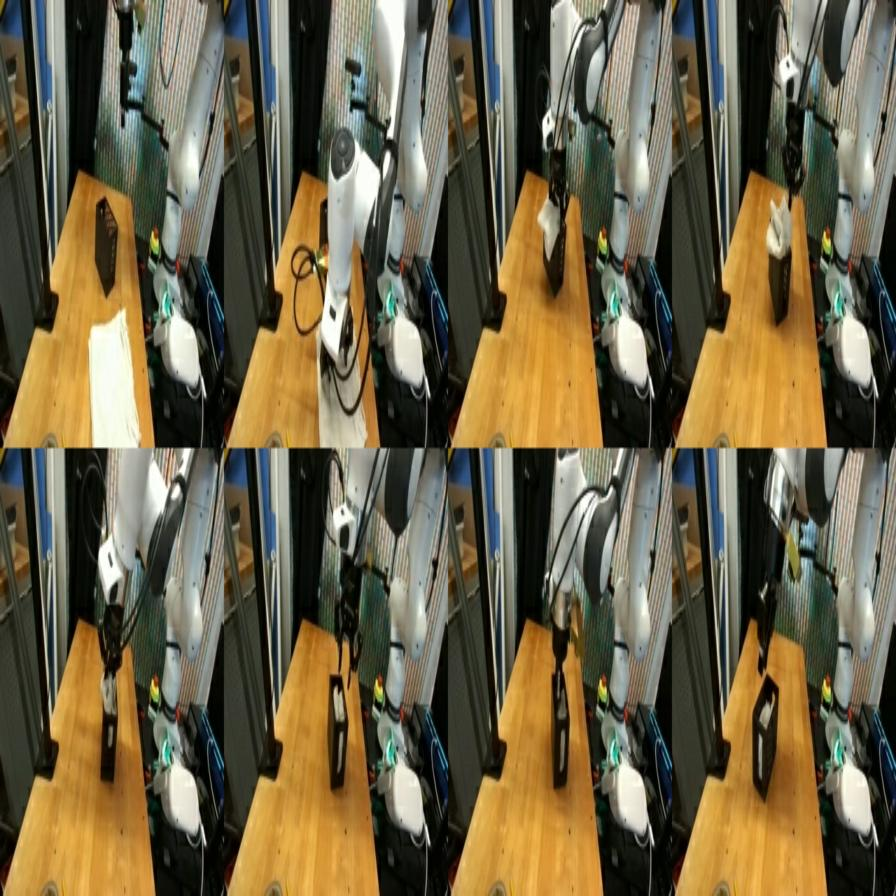
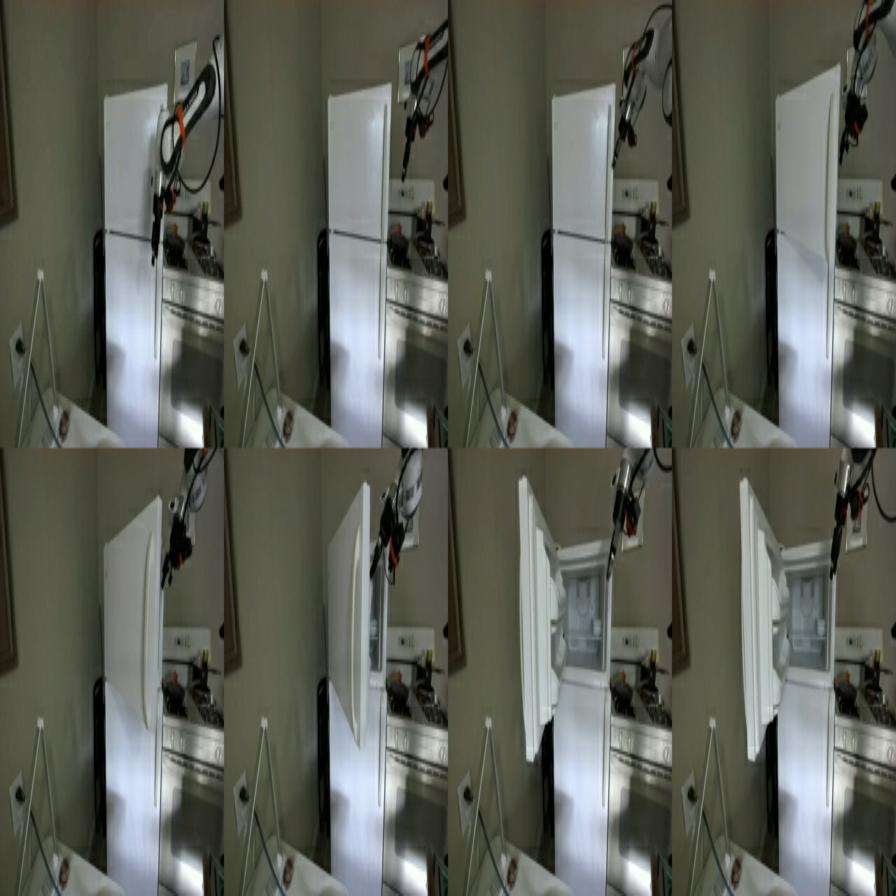
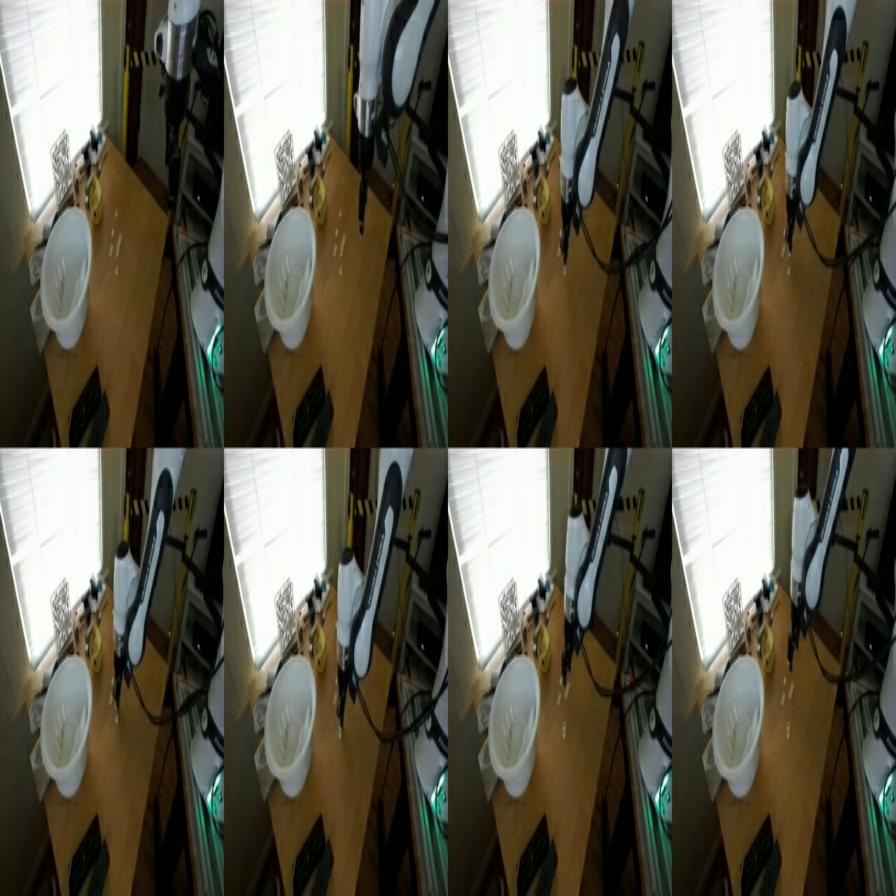
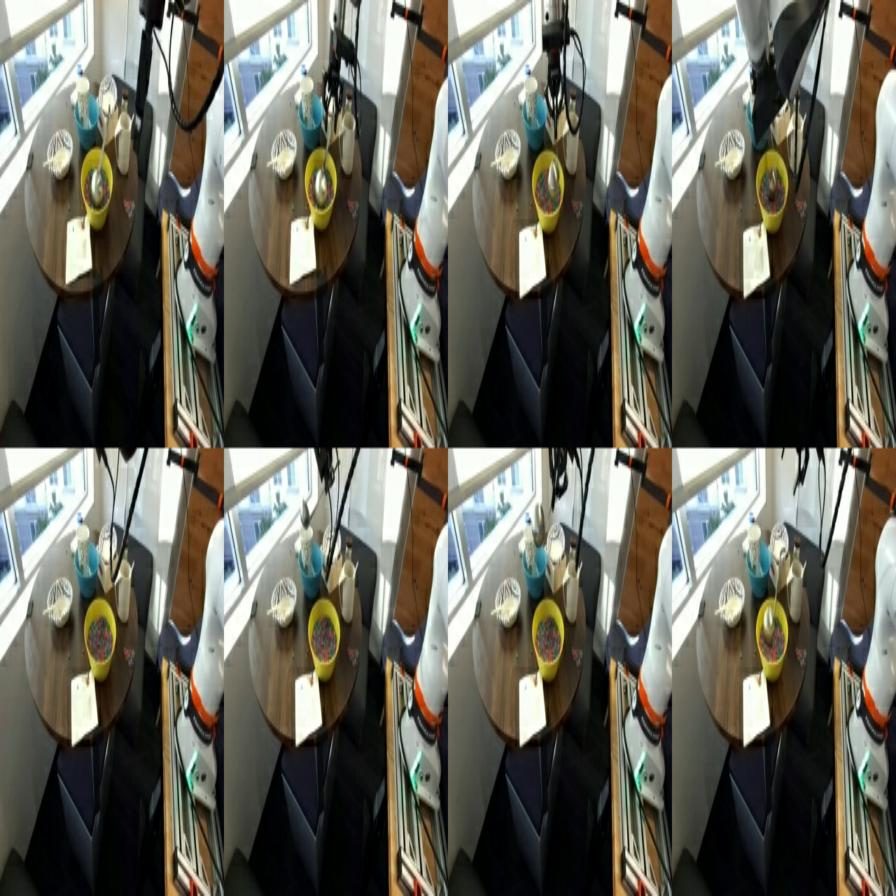

: 

In [ ]:
# The validation data consists of 10 images in a different domain than training
# data.
# %%time

print("Model predictions")
html_out = ""
for image, caption in make_predictions(validation_data_iterator(), batch_size=4):
  html_out += render_example(image, caption)
display(HTML(html_out))


In [22]:
import os
print("This notebook kernel’s PID is", os.getpid())


This notebook kernel’s PID is 1134912


In [5]:
def load_checkpoint(path):
    with open(path, "rb") as f:
        return flax.serialization.from_bytes(params, f.read())
load_checkpoint("checkpoints/checkpoint_0001.msgpack")

NameError: name 'params' is not defined

In [22]:
import os
import flax

from big_vision.models.proj.paligemma import paligemma
import ml_collections, sentencepiece, jax

# (re)build the same model_config and TOKENIZER as before…
LLM_VARIANT = "gemma2_2b"

model_config = ml_collections.FrozenConfigDict({
    "llm": {"vocab_size": 257_152, "variant": LLM_VARIANT, "final_logits_softcap": 0.0},
    "img": {"variant": "So400m/14", "pool_type": "none", "scan": True, "dtype_mm": "float16"}
})
init_params = paligemma.load(None, MODEL_PATH, model_config)


def load_checkpoint(template_params, step, save_dir="checkpoints"):
    """
    template_params: a pytree of the same structure as your saved params,
                     e.g. the output of your model's init().
    step: integer step number that matches the filename.
    """
    path = "/home/henrytsai/checkpoints/checkpoint_0001.msgpack"
    with open(path, "rb") as f:
        raw = f.read()
    # Rebuild the params pytree from bytes
    return flax.serialization.from_bytes(template_params, raw)

# — usage — 
# assume `init_params` is what you got from your model’s init call
params = load_checkpoint(init_params, step=1)


In [23]:
params

html_out = ""
for image, caption in make_predictions(
        validation_data_iterator(),
        num_examples=None,    # ← use None to run through the whole split
        batch_size=4,         # ← or bump this up if you like
        seqlen=SEQLEN,
        sampler="greedy"      # ← or "beam", etc.
    ):
    html_out += render_example(image, caption)

# 3) Display them
display(HTML(html_out))

NameError: name 'make_predictions' is not defined